In [85]:
import librosa
import librosa.display
import madmom
import matplotlib.pyplot as plt
import numpy as np
import os
import pyrubberband as pyrb
import soundfile
import soundfile as sf
import subprocess
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from IPython.display import Audio
from itertools import groupby
from madmom.features.downbeats import DBNDownBeatTrackingProcessor, RNNDownBeatProcessor
from operator import itemgetter
from pydub import AudioSegment
from scipy.io.wavfile import write
from scipy.signal import find_peaks
from scipy.stats import mode
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from yodel.filter import yodel

In [5]:
def detect_downbeats(audio_file, sr=44100, fps=100):
    # Load the audio signal without resampling
    signal = madmom.audio.signal.Signal(audio_file, sample_rate=sr, num_channels=1)
    
    # Get the beat and downbeat activations
    act = madmom.features.RNNDownBeatProcessor()(signal)
    
    # Create a downbeat processor
    proc = madmom.features.DBNDownBeatTrackingProcessor(beats_per_bar=[4], fps=fps)
    
    # Get the beats and downbeats
    beats_and_downbeats = proc(act)
    
    # Filter downbeats (those with beat position 1)
    downbeats = [beat for beat in beats_and_downbeats if beat[1] == 1]

    return np.array(downbeats)

from scipy.stats import mode

def estimate_tempo_from_downbeats(audio_file, downbeats):
    
    # Calculate the time difference between consecutive downbeats
    downbeat_differences = np.diff(downbeats[:, 0])

    # Calculate the time difference between consecutive downbeats
    downbeat_differences = np.around(np.diff(downbeats[:, 0]), decimals=6)

    # Get the mode of the differences
    mod_diff = mode(downbeat_differences).mode

    # Calculate the tempo: 60 seconds divided by the average difference
    # Since downbeat_differences are in seconds, this gives beats per minute
    tempo = 4 * (60 / mod_diff)
    
    tempo = round(tempo)

    return tempo, mod_diff, downbeat_differences

def estimate_beat(audio_file, sr=44100):
    try:
        # Load the audio signal with the specified sample rate
        signal = madmom.audio.signal.Signal(audio_file, sample_rate=sr, num_channels=1)
        
        # Consider only 4/4 time signature
        proc = DBNDownBeatTrackingProcessor(beats_per_bar=[4], fps=100)
        act = RNNDownBeatProcessor()(signal)
        proc_res = proc(act)
        
        # Extract the beat timestamps
        beat_timestamps = proc_res[:, 0]
        
        return beat_timestamps
    
    except Exception as e:
        print(e)
        return np.array([])  # Return an empty array for better consistency

In [6]:
class SimpleTrack:
    def __init__(self, name, wav_file):
        self.name = name
        self.wav_file = wav_file
        self.audio, self.sr = librosa.load(wav_file, sr=None)
        self.downbeats = None
        self.beats = None
        self.tempo = None
        self.cueyes = None
        self.cueno = None
        self.time_signature = None
        self.x_tensor = None
        self.cue_points = None
        self.cue_points_indeces = None 
        
    def prepare_features_for_prediction(self):
        X_new = [self.convert_to_feature_vector(f) for f in self.features]
        X_new = scaler.transform(X_new)  # Normalize
        self.x_tensor = torch.FloatTensor(X_new).unsqueeze(0)
        
    
    def detect_downbeats(self):
        self.downbeats = detect_downbeats(self.wav_file)

    def estimate_tempo_from_downbeats(self):
        self.tempo, _, self.downbeat_differences = estimate_tempo_from_downbeats(self.wav_file, self.downbeats)
        
    def estimate_beat(self):
        self.beats = estimate_beat(self.wav_file)
        
    # 1. Convert the extracted features into flat feature vectors
    def convert_to_feature_vector(self, beat_features):
        """Convert beat features into a flattened feature vector."""
        flat_features = list(beat_features['MFCC']) + \
                        list(beat_features['Spectral Contrast']) + \
                        [beat_features['Spectral Centroid']] + \
                        [beat_features['Spectral Rolloff']] + \
                        [beat_features['Spectral Flux']] + \
                        [beat_features['RMS']]
        return flat_features

In [7]:
# specify your path for the training set 

path = "kasi"

raw_wav_files = [os.path.join(path, file_name) for file_name in os.listdir(path) if file_name.endswith('.wav')]

raw_tracks = {}
counter = {}

for wav_file in raw_wav_files:
    track_name = (os.path.basename(wav_file))
    if track_name in counter:
        counter[track_name] += 1
        track_name = f"{track_name}{counter[tracaaaaak_name]}"
    else:
        counter[track_name] = 1
    track = SimpleTrack(track_name, wav_file)
    raw_tracks[track_name] = track

tracks = raw_tracks

In [8]:
tracks

{'CAIVA - RAW Summer Hits 4 • Original Tracks - 17 The Love Inside Me.wav': <__main__.SimpleTrack at 0x10f9d6fd0>,
 'BEADS - SET THE TEMPO.wav': <__main__.SimpleTrack at 0x189b5e0d0>,
 'PETERBLUE - Latin Club (Reformist Remix).wav': <__main__.SimpleTrack at 0x1751882d0>,
 'Bad Boombox - RAW Summer Hits 4 • Original Tracks - 20 Gushy (Ft. MC Yung Lil).wav': <__main__.SimpleTrack at 0x175aba010>,
 'DJ SWISHERMAN - Big Boy [RYS002].wav': <__main__.SimpleTrack at 0x1751277d0>,
 'Gene Richards Jr - The Feeder (Chlär & Chontane Remix).wav': <__main__.SimpleTrack at 0x175ab88d0>,
 'Shannen Blessing - Take Me Out.wav': <__main__.SimpleTrack at 0x189b5e190>,
 'Dallaniel - RAW Summer Hits 4 • Original Tracks - 14 Somebody Else.wav': <__main__.SimpleTrack at 0x189b952d0>,
 "SJUSH - Pacman's Deathwish.wav": <__main__.SimpleTrack at 0x175184190>,
 'The Chronics - RAW Summer Hits 4 • Original Tracks - 13 Luz.wav': <__main__.SimpleTrack at 0x189b97b50>,
 'RUIZ OSC1 - RAW Summer Hits 4 • Original Trac

In [9]:
def preprocess_simple_track(track):
    
    # Detect downbeats
    track.detect_downbeats()
    
    # Estimate tempo from downbeats
    track.estimate_tempo_from_downbeats()
    
    print(f"Estimated Tempo for {track.name}: {track.tempo:.2f} BPM")
    track.estimate_beat()

In [10]:
# Calling the preprocess function on each track in the tracks dictionary
for track_name, track_obj in tracks.items():
    print(f"Preprocessing : {track_obj.name}")
    preprocess_simple_track(track_obj)

Preprocessing : CAIVA - RAW Summer Hits 4 • Original Tracks - 17 The Love Inside Me.wav
Estimated Tempo for CAIVA - RAW Summer Hits 4 • Original Tracks - 17 The Love Inside Me.wav: 149.00 BPM
Preprocessing : BEADS - SET THE TEMPO.wav
Estimated Tempo for BEADS - SET THE TEMPO.wav: 143.00 BPM
Preprocessing : PETERBLUE - Latin Club (Reformist Remix).wav
Estimated Tempo for PETERBLUE - Latin Club (Reformist Remix).wav: 145.00 BPM
Preprocessing : Bad Boombox - RAW Summer Hits 4 • Original Tracks - 20 Gushy (Ft. MC Yung Lil).wav
Estimated Tempo for Bad Boombox - RAW Summer Hits 4 • Original Tracks - 20 Gushy (Ft. MC Yung Lil).wav: 157.00 BPM
Preprocessing : DJ SWISHERMAN - Big Boy [RYS002].wav
Estimated Tempo for DJ SWISHERMAN - Big Boy [RYS002].wav: 145.00 BPM
Preprocessing : Gene Richards Jr - The Feeder (Chlär & Chontane Remix).wav
Estimated Tempo for Gene Richards Jr - The Feeder (Chlär & Chontane Remix).wav: 145.00 BPM
Preprocessing : Shannen Blessing - Take Me Out.wav
Estimated Tempo f

### REKORDBOX 

In [11]:
aligned_track_names = {
    'Amniote Editions - JD Typo - Txtural': 'Amniote',
    'BEADS - SET THE TEMPO': 'BEADS',
    'DJ SWISHERMAN - Big Boy [RYS002]': 'DJ',
    'Gene Richards Jr - The Feeder (Chlär & Chontane Remix)': 'Gene',
    'JASØN - JASØN - Fura (Edvvin Remix)': 'JASØN',
    'kvlr - The Navigator [MASTER]': 'kvlr',
    'MiniTribe - Pharpheonix': 'MiniTribe',
    'PETERBLUE - Latin Club (Reformist Remix)': 'PETERBLUE',
    'Seigg - Needless': 'Seigg',
    "SJUSH - Pacman's Deathwish": 'SJUSH',
    'Shannen Blessing - Take Me Out': 'Shannen',
    'Stef de Haan - In 4 The Kill (Stef de Haan Remix)': 'Stef',
    'Bad Boombox - RAW Summer Hits 4 • Original Tracks - 20 Gushy (Ft. MC Yung Lil)': 'Bad',
    'CAIVA - RAW Summer Hits 4 • Original Tracks - 17 The Love Inside Me': 'CAIVA',
    'Dallaniel - RAW Summer Hits 4 • Original Tracks - 14 Somebody Else': 'Dallaniel',
    'Dylan Fogarty - RAW Summer Hits 4 • Original Tracks - 02 Da Funky Track': 'Dylan',
    'Mac Declos & LAZE - RAW Summer Hits 4 • Original Tracks - 19 Wanted Prisma': 'Mac',
    'RUIZ OSC1 - RAW Summer Hits 4 • Original Tracks - 03 Snare 3000': 'RUIZ',
    'The Chronics - RAW Summer Hits 4 • Original Tracks - 13 Luz': 'The'}

In [12]:
import xml.etree.ElementTree as ET

def extract_hot_cues_for_aligned_tracks(xml_file_path, aligned_track_names):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    hot_cue_points = {}
    
    # Iterate over all tracks in the XML
    for track in root.findall(".//TRACK"):
        track_name = track.get("Name")
        if track_name not in aligned_track_names:
            continue  # skip tracks not in the alignment
        
        cues = []
        for cue in track.findall(".//POSITION_MARK"):
            # Convert the start time from milliseconds to seconds
            start_time = float(cue.get("Start"))
            cues.append(start_time)
            
        hot_cue_points[track_name] = cues

    return hot_cue_points

# Usage:
rekordbox_xml_path = "rekordbox_meta_data.xml"
cue_points = extract_hot_cues_for_aligned_tracks(rekordbox_xml_path, aligned_track_names)
print(cue_points)


{'kvlr - The Navigator [MASTER]': [6.488, 32.434, 58.38, 84.326, 110.272, 136.218, 162.164, 188.11], 'MiniTribe - Pharpheonix': [22.587, 56.47, 101.646, 124.235, 180.705, 192.0, 293.647], 'DJ SWISHERMAN - Big Boy [RYS002]': [0.112, 26.595, 39.837, 66.319, 112.664, 125.906, 152.388, 178.871], 'Amniote Editions - JD Typo - Txtural': [78.416, 143.722, 182.906, 195.967, 261.273, 287.395, 365.762, 378.824], 'BEADS - SET THE TEMPO': [0.001, 28.533, 62.099, 88.952, 162.799, 218.183, 189.652, 246.715], 'Gene Richards Jr - The Feeder (Chlär & Chontane Remix)': [0.026, 26.509, 145.681, 211.888, 238.371, 92.716], 'JASØN - JASØN - Fura (Edvvin Remix)': [0.001, 27.43, 54.859, 96.002, 123.43, 137.145, 150.859, 192.002], 'PETERBLUE - Latin Club (Reformist Remix)': [0.023, 26.505, 52.988, 105.954, 132.437, 185.402, 225.126], 'Seigg - Needless': [3.426, 13.712, 82.284, 123.427, 226.284, 239.998, 282.855, 164.569], 'Shannen Blessing - Take Me Out': [0.002, 12.551, 47.061, 97.257, 163.139, 247.845], "SJU

In [13]:
for track_name, track_obj in tracks.items():
    track_name_without_extension = track_name.replace('.wav', '')
    if track_name_without_extension in cue_points:
        track_obj.cueyes = cue_points[track_name_without_extension]
    else:
        print(f"No hot cues found for track name: {track_name}")

In [14]:
for track_name, track_obj in tracks.items():
    print(f"Track Name: {track_name}")
    print(f"Hot Cue Points: {track_obj.cueyes}")
    print("=====================================")


Track Name: CAIVA - RAW Summer Hits 4 • Original Tracks - 17 The Love Inside Me.wav
Hot Cue Points: [0.05, 12.936, 51.594, 80.587, 180.453, 206.225, 231.997, 128.909]
Track Name: BEADS - SET THE TEMPO.wav
Hot Cue Points: [0.001, 28.533, 62.099, 88.952, 162.799, 218.183, 189.652, 246.715]
Track Name: PETERBLUE - Latin Club (Reformist Remix).wav
Hot Cue Points: [0.023, 26.505, 52.988, 105.954, 132.437, 185.402, 225.126]
Track Name: Bad Boombox - RAW Summer Hits 4 • Original Tracks - 20 Gushy (Ft. MC Yung Lil).wav
Hot Cue Points: [12.28, 36.739, 61.197, 85.656, 134.573, 146.802, 195.719, 269.095]
Track Name: DJ SWISHERMAN - Big Boy [RYS002].wav
Hot Cue Points: [0.112, 26.595, 39.837, 66.319, 112.664, 125.906, 152.388, 178.871]
Track Name: Gene Richards Jr - The Feeder (Chlär & Chontane Remix).wav
Hot Cue Points: [0.026, 26.509, 145.681, 211.888, 238.371, 92.716]
Track Name: Shannen Blessing - Take Me Out.wav
Hot Cue Points: [0.002, 12.551, 47.061, 97.257, 163.139, 247.845]
Track Name: Dal

In [15]:
def plot_audio_segment_with_beats_and_cues(audio, sr, beats, cue_points, start_time, duration):
    # Calculate start and end samples
    start_sample = int(start_time * sr)
    end_sample = start_sample + int(duration * sr)

    # Create time array
    time = np.arange(start_sample, end_sample) / sr

    # Identify beats and cue points in the segment
    segment_beats = [beat for beat in beats if start_time <= beat < start_time + duration]

    segment_cues = [float(cue) for cue in cue_points if start_time <= float(cue) < start_time + duration]


    # Plot audio segment
    plt.figure(figsize=(10, 4))
    plt.plot(time, audio[start_sample:end_sample])
    plt.vlines(segment_beats, ymin=np.min(audio), ymax=np.max(audio), colors='r', label='Beats')
    plt.vlines(segment_cues, ymin=np.min(audio), ymax=np.max(audio), colors='b', linestyle='dashed', label='Cue Points')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Audio Segment with Beats and Cue Points')
    plt.legend()
    plt.xlim([start_time, start_time + duration])
    plt.show()
    


Plotting for track: CAIVA - RAW Summer Hits 4 • Original Tracks - 17 The Love Inside Me.wav


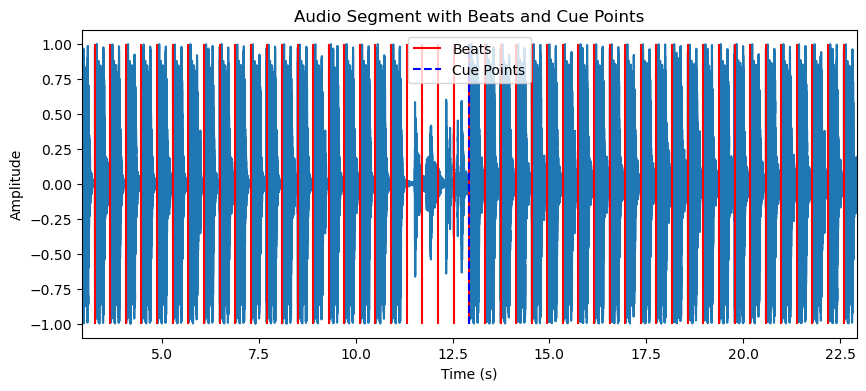

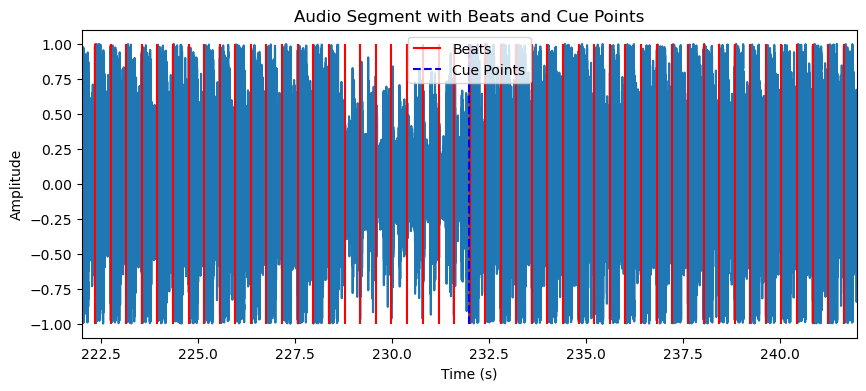

Plotting for track: BEADS - SET THE TEMPO.wav


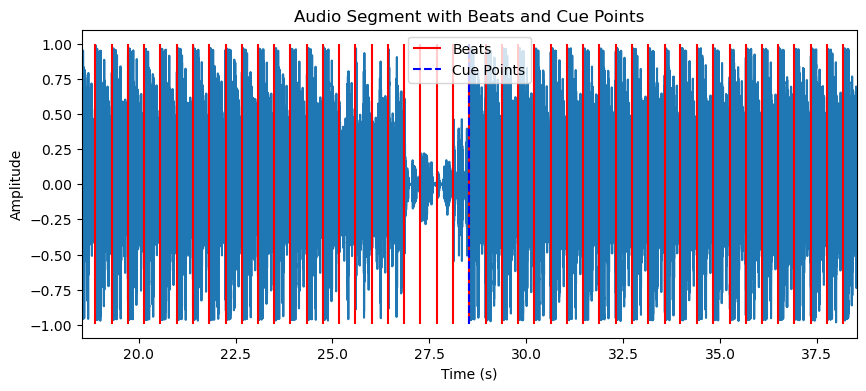

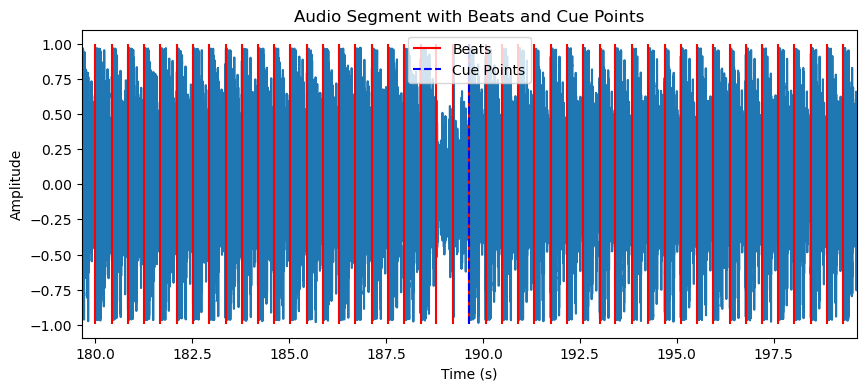

Plotting for track: PETERBLUE - Latin Club (Reformist Remix).wav


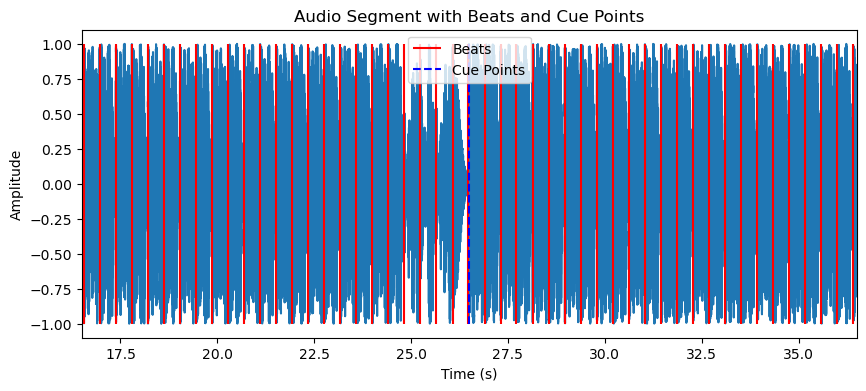

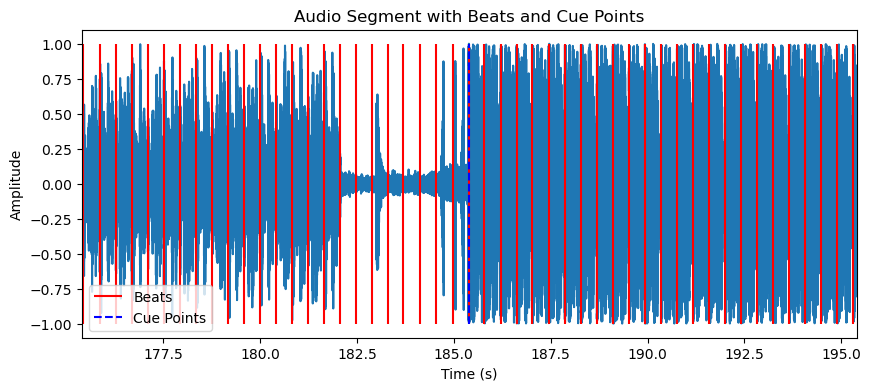

Plotting for track: Bad Boombox - RAW Summer Hits 4 • Original Tracks - 20 Gushy (Ft. MC Yung Lil).wav


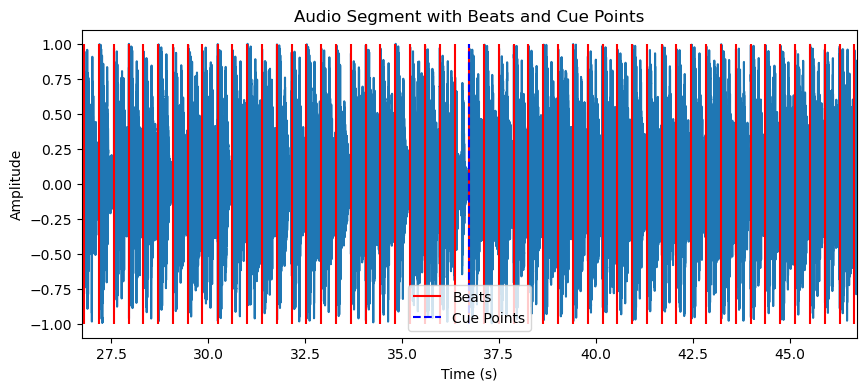

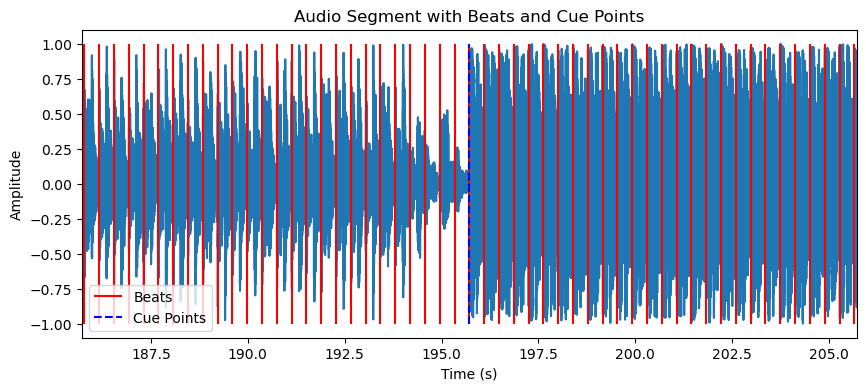

Plotting for track: DJ SWISHERMAN - Big Boy [RYS002].wav


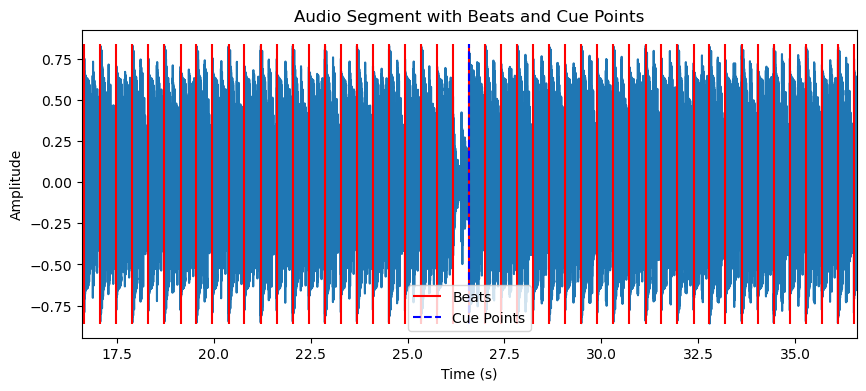

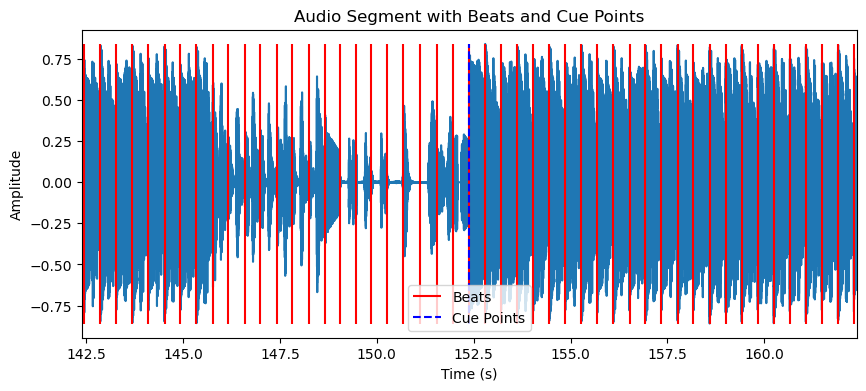

Plotting for track: Gene Richards Jr - The Feeder (Chlär & Chontane Remix).wav


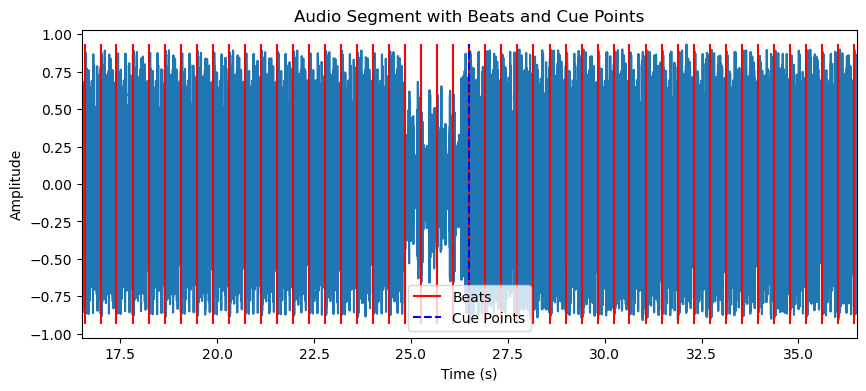

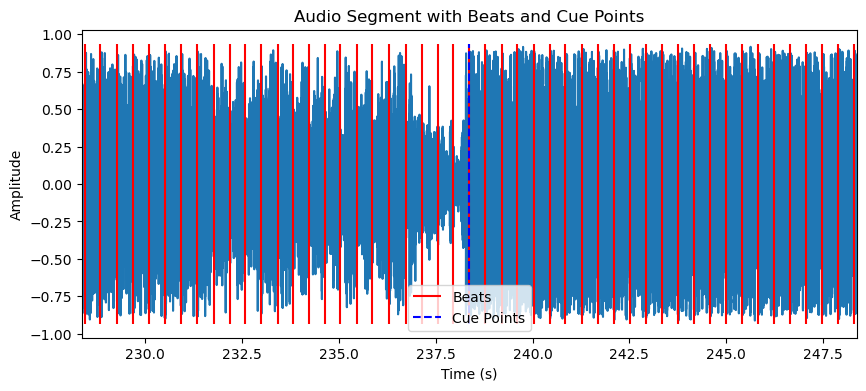

Plotting for track: Shannen Blessing - Take Me Out.wav


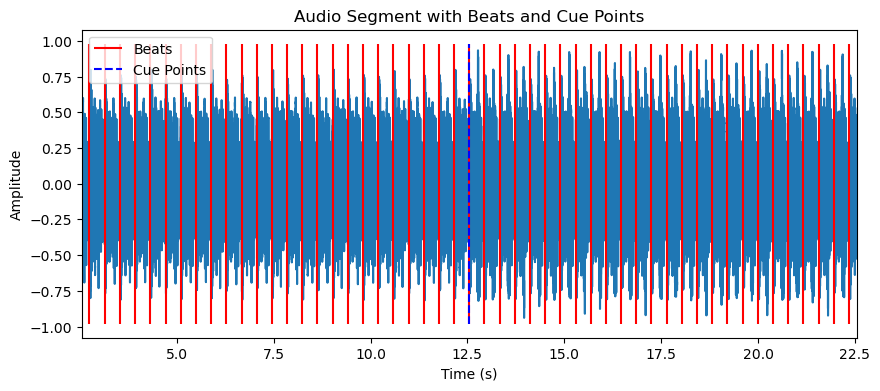

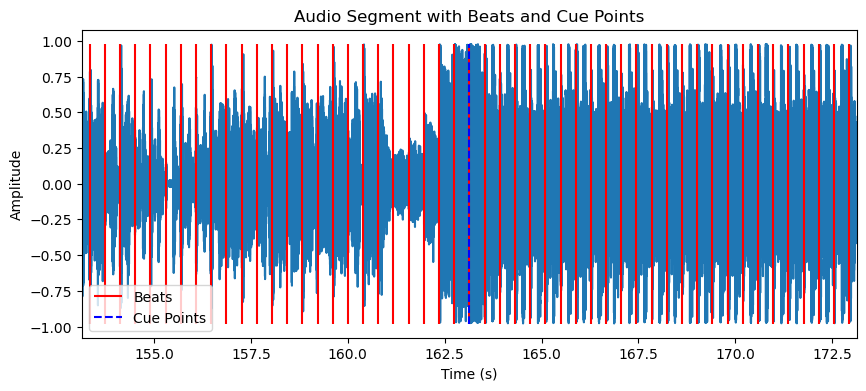

Plotting for track: Dallaniel - RAW Summer Hits 4 • Original Tracks - 14 Somebody Else.wav


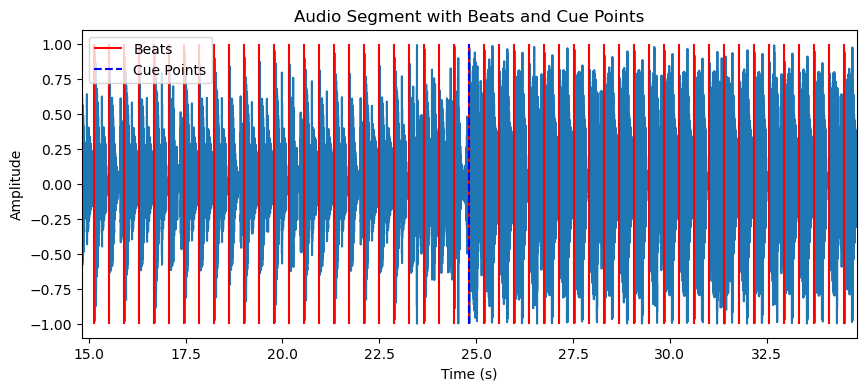

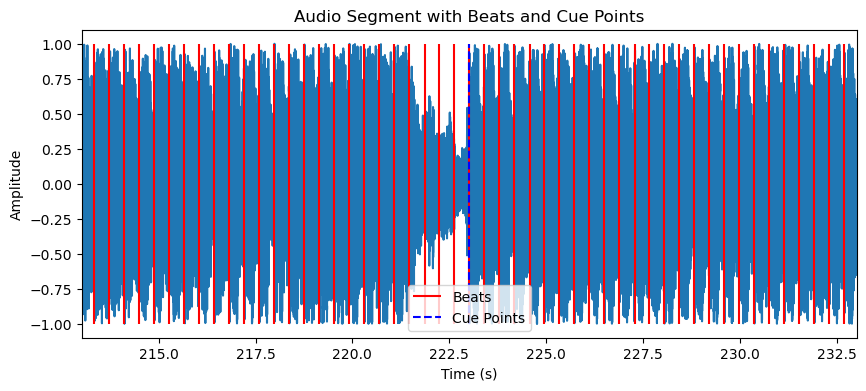

Plotting for track: SJUSH - Pacman's Deathwish.wav


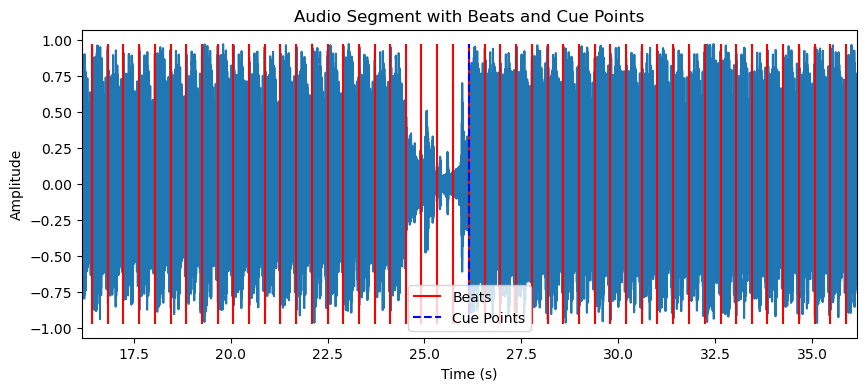

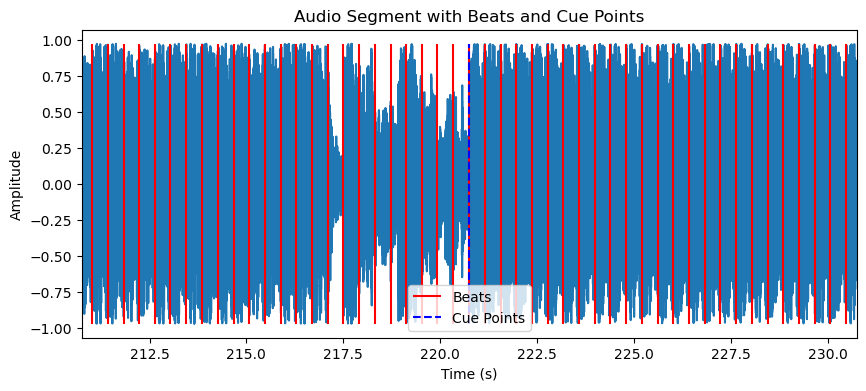

Plotting for track: The Chronics - RAW Summer Hits 4 • Original Tracks - 13 Luz.wav


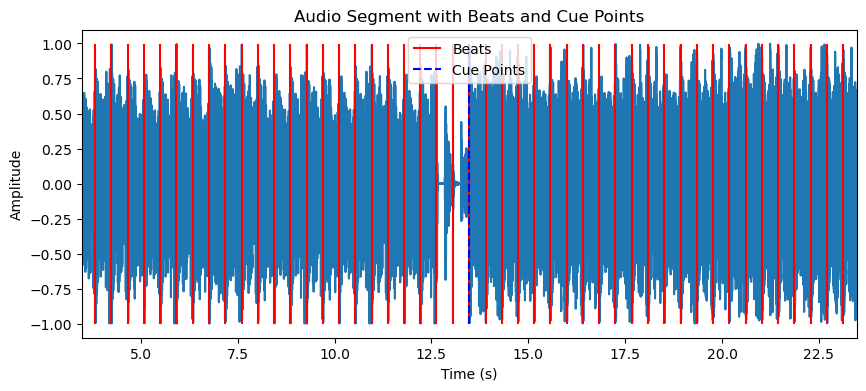

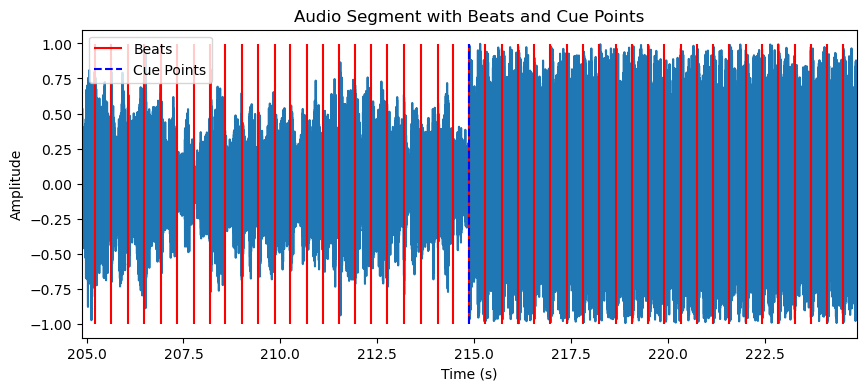

Plotting for track: RUIZ OSC1 - RAW Summer Hits 4 • Original Tracks - 03 Snare 3000.wav


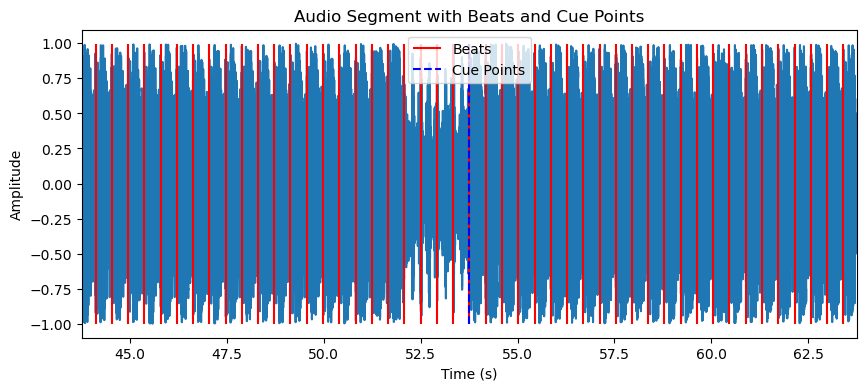

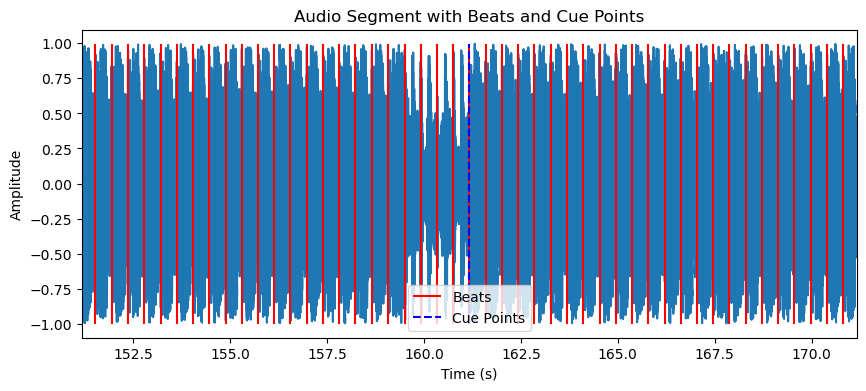

Plotting for track: Dylan Fogarty - RAW Summer Hits 4 • Original Tracks - 02 Da Funky Track.wav


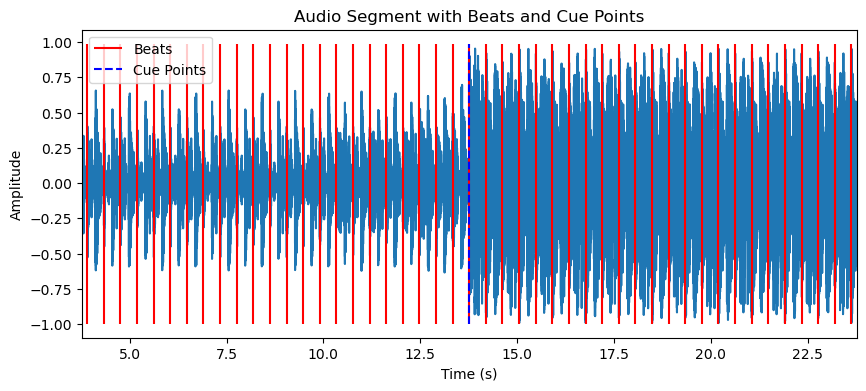

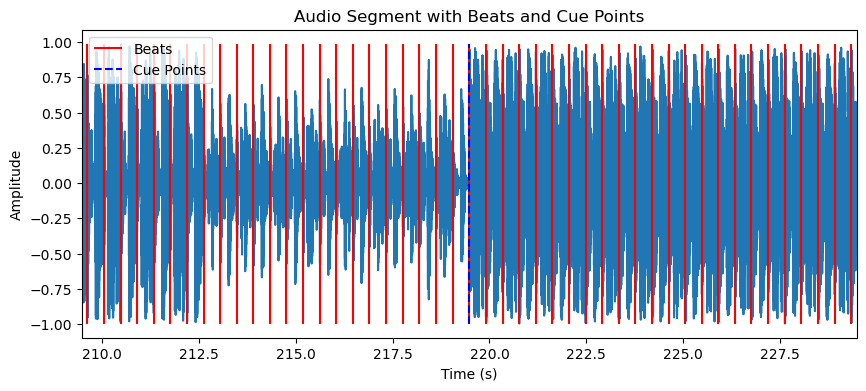

Plotting for track: Seigg - Needless.wav


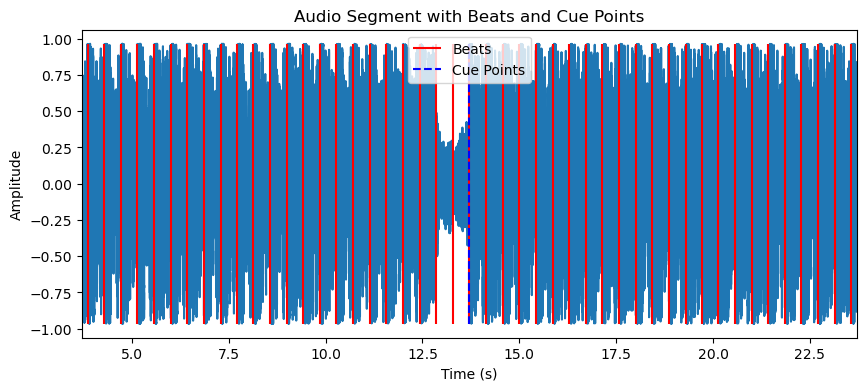

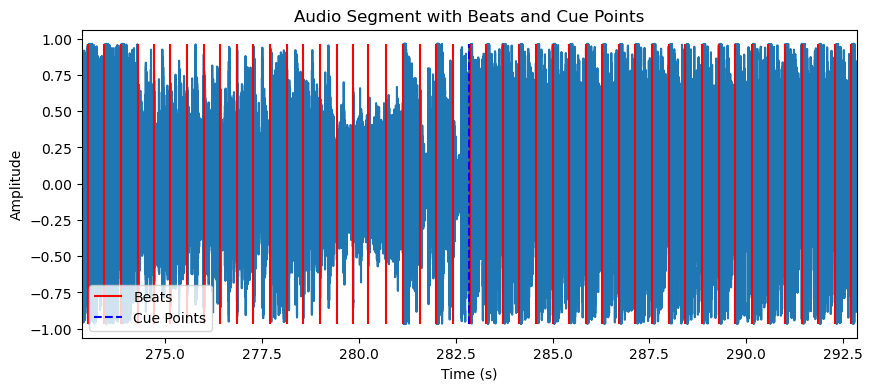

Plotting for track: Mac Declos & LAZE - RAW Summer Hits 4 • Original Tracks - 19 Wanted Prisma.wav


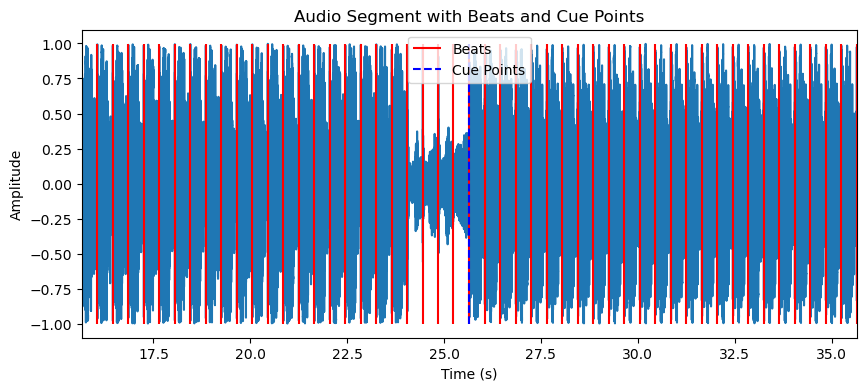

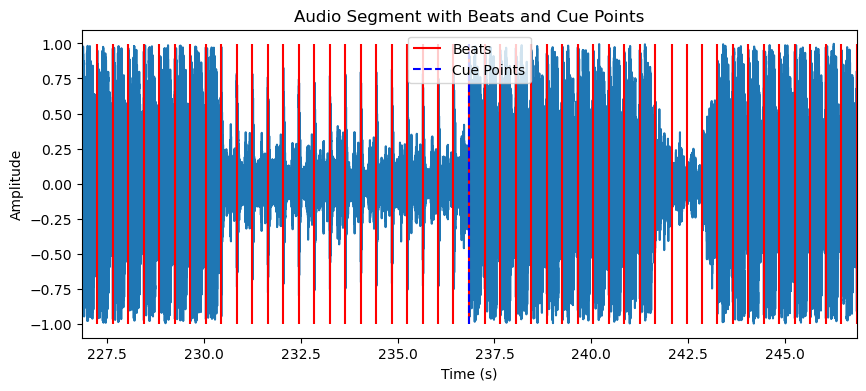

Plotting for track: MiniTribe - Pharpheonix.wav


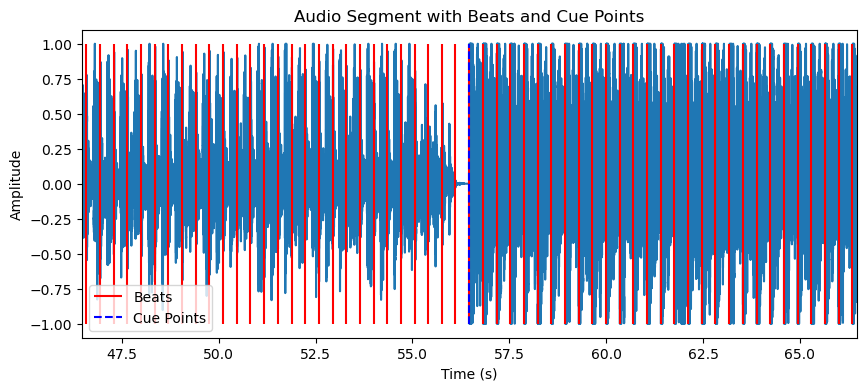

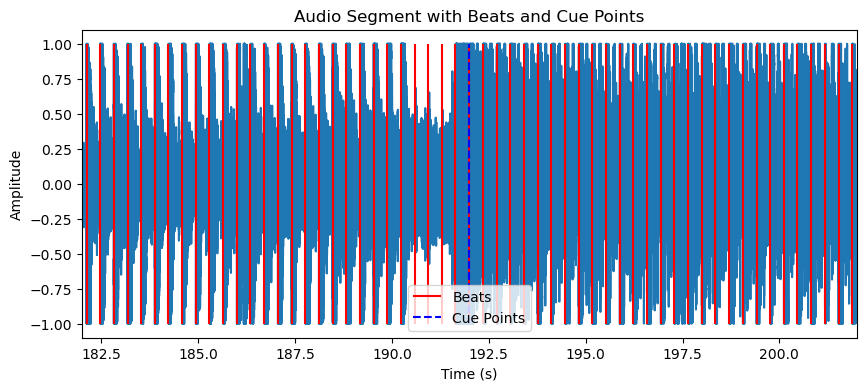

Plotting for track: JASØN - JASØN - Fura (Edvvin Remix).wav


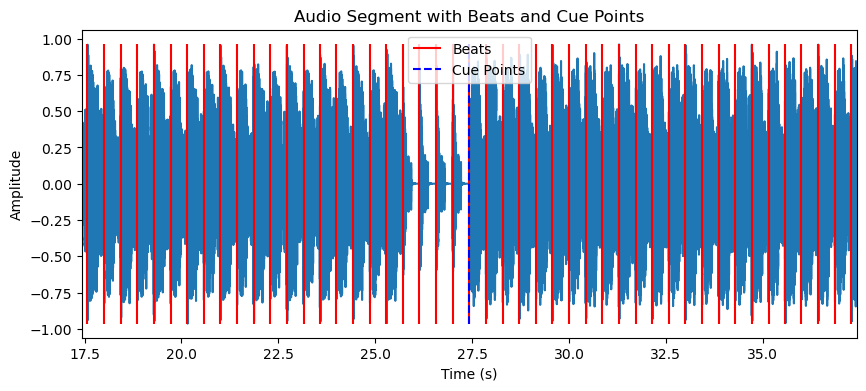

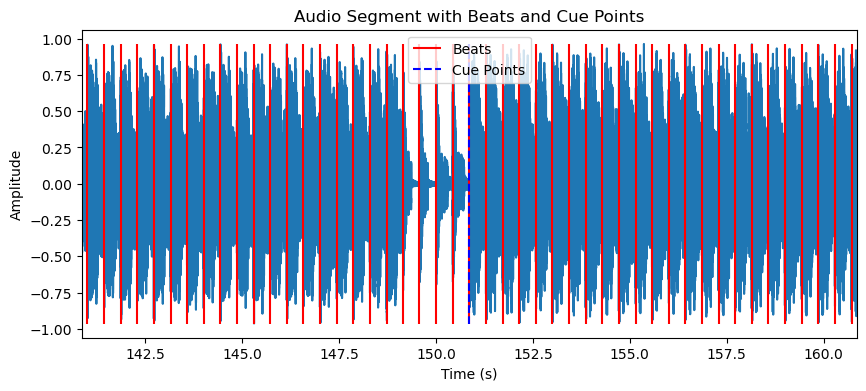

Plotting for track: kvlr - The Navigator [MASTER].wav


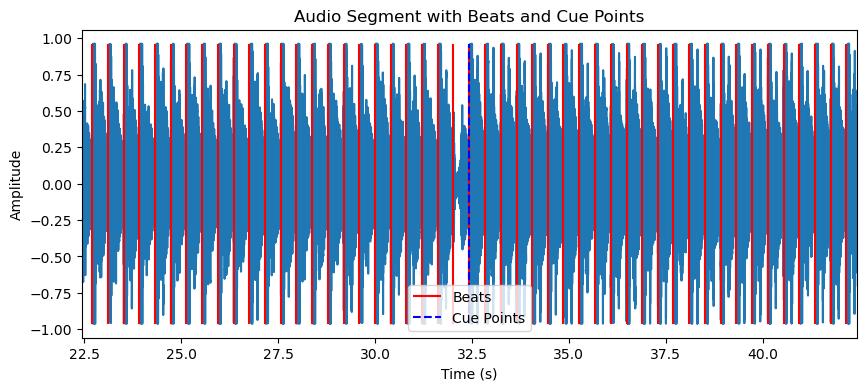

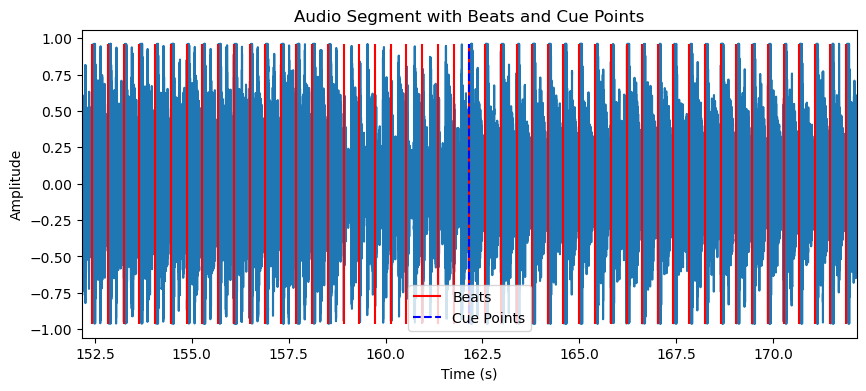

Plotting for track: Stef de Haan - In 4 The Kill (Stef de Haan Remix).wav


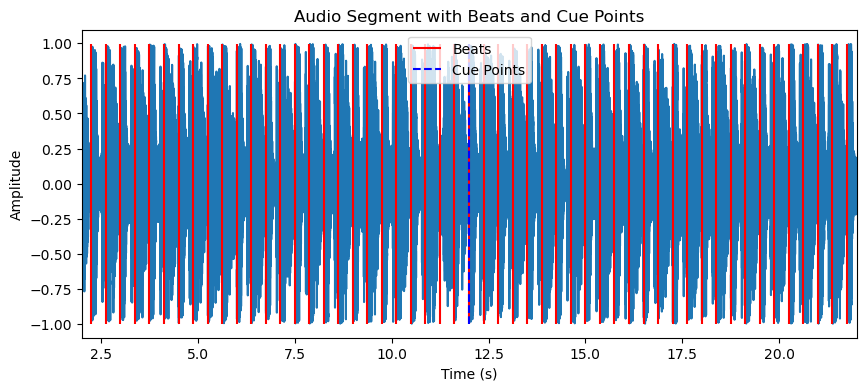

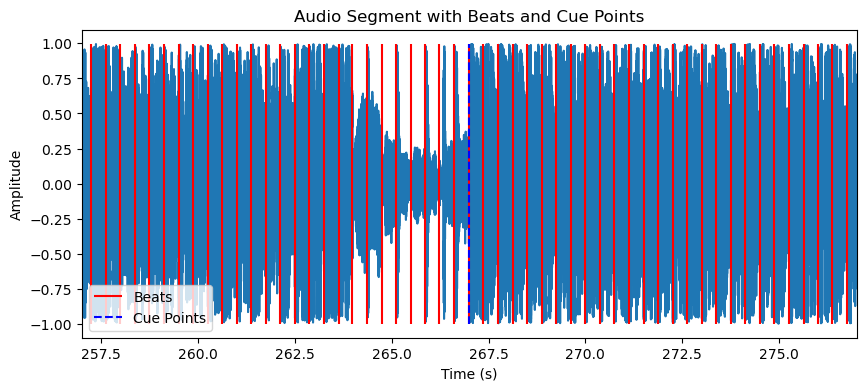

Plotting for track: Amniote Editions - JD Typo - Txtural.wav


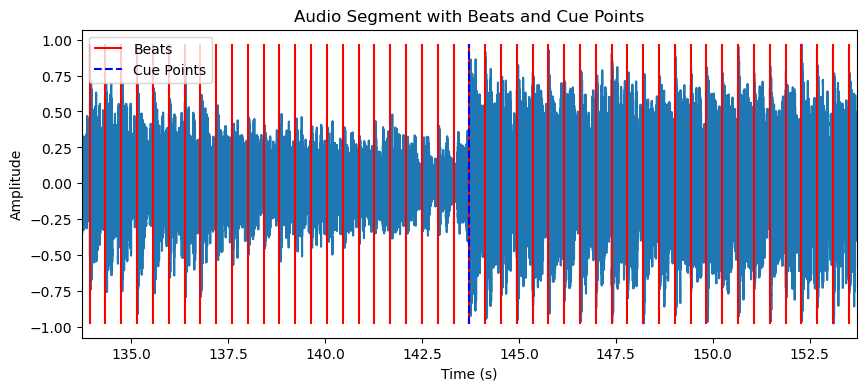

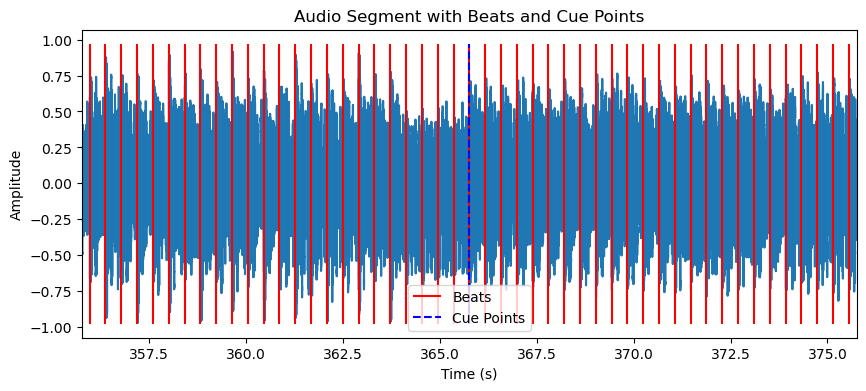

In [16]:
def plot_audio_segment_around_first_and_last_cue(audio, sr, beats, cue_points):
    # Extract only the first and last cue points
    first_cue = cue_points[1]
    last_cue = cue_points[-2]
    selected_cue_points = [first_cue, last_cue]
    
    for cue in selected_cue_points:
        cue = float(cue)  # Convert cue point from string to float
        
        # Define start time and duration for the segment centered around the cue point
        start_time = max(cue - 10, 0)  # Ensure the start time is not negative
        duration = 20
        
        # Calculate end time, ensuring it doesn't exceed the length of the audio
        end_time = min(cue + 10, len(audio) / sr)
        
        # Adjust duration if end_time is at the end of the audio
        if end_time == len(audio) / sr:
            start_time = end_time - 20
        
        # If cue point is near the beginning or end, adjust start_time to ensure cue is within plotting window
        if cue - start_time < 5:  # If cue is within first 5 seconds of window
            start_time = cue - 5
        elif end_time - cue < 5:  # If cue is within last 5 seconds of window
            start_time = cue - 15

        # Ensure start_time and duration values are valid
        start_time = max(0, start_time)
        duration = min(duration, len(audio) / sr - start_time)

        # Plot the segment
        plot_audio_segment_with_beats_and_cues(audio, sr, beats, np.array(selected_cue_points), start_time, duration)

for track_name, track in tracks.items():
    print(f"Plotting for track: {track_name}")
    audio = track.audio
    sr = track.sr
    beats = track.beats
    cue_points = track.cueyes  # Use the cue_points attribute of the track
    plot_audio_segment_around_first_and_last_cue(audio, sr, beats, cue_points)

In [17]:
def label_cues(beats, cueyes):
    """Label the cues and their neighbors."""
    # Start with an array of -1 (unlabeled)
    labels = np.ones(len(beats)) * -1

    # Convert cueyes to indices
    cueyes_indices = []
    for cue in cueyes:
        cue_index = np.argmin(np.abs(np.array(beats) - cue))
        cueyes_indices.append(cue_index)
        labels[cue_index] = 1

    # Label the neighboring beats within the radius
    cueno_indices = []
    for idx in cueyes_indices:
        for offset in range(-3, 4):  # Include the range from -3 to 3
            if 0 <= idx + offset < len(beats) and offset != 0:  # Check boundaries and exclude the cue itself
                labels[idx + offset] = 0
                cueno_indices.append(idx + offset)

    # Diagnostic print statements
    print("Cueyes Indices:", cueyes_indices)
    print("Cueno Indices:", cueno_indices)

    return labels, cueyes_indices, cueno_indices

# Apply the function to all tracks
for track_name, track in tracks.items():
    track.labels, track.cueyes, track.cueno = label_cues(track.beats, track.cueyes)

Cueyes Indices: [0, 32, 128, 200, 448, 512, 576, 320]
Cueno Indices: [1, 2, 3, 29, 30, 31, 33, 34, 35, 125, 126, 127, 129, 130, 131, 197, 198, 199, 201, 202, 203, 445, 446, 447, 449, 450, 451, 509, 510, 511, 513, 514, 515, 573, 574, 575, 577, 578, 579, 317, 318, 319, 321, 322, 323]
Cueyes Indices: [0, 68, 148, 212, 388, 520, 452, 588]
Cueno Indices: [1, 2, 3, 65, 66, 67, 69, 70, 71, 145, 146, 147, 149, 150, 151, 209, 210, 211, 213, 214, 215, 385, 386, 387, 389, 390, 391, 517, 518, 519, 521, 522, 523, 449, 450, 451, 453, 454, 455, 585, 586, 587, 589, 590, 591]
Cueyes Indices: [0, 64, 128, 256, 320, 448, 544]
Cueno Indices: [1, 2, 3, 61, 62, 63, 65, 66, 67, 125, 126, 127, 129, 130, 131, 253, 254, 255, 257, 258, 259, 317, 318, 319, 321, 322, 323, 445, 446, 447, 449, 450, 451, 541, 542, 543, 545, 546, 547]
Cueyes Indices: [32, 96, 160, 224, 352, 384, 512, 704]
Cueno Indices: [29, 30, 31, 33, 34, 35, 93, 94, 95, 97, 98, 99, 157, 158, 159, 161, 162, 163, 221, 222, 223, 225, 226, 227, 349, 35

In [18]:
total_cueyes = 0
total_cueno = 0

for track_name, track in tracks.items():
    total_cueyes += len(track.cueyes)
    total_cueno += len(track.cueno)

print(f"Total Cueyes: {total_cueyes}")
print(f"Total Cueno: {total_cueno}")

Total Cueyes: 140
Total Cueno: 807


In [19]:
import librosa
import numpy as np

def extract_features(audio, sr, timestamp, window_size=1.0):
    """
    Extract multiple audio features for a given timestamp using librosa.
    
    Parameters:
    - audio: The audio data as a numpy array.
    - sr: Sample rate.
    - timestamp: The given timestamp (in seconds).
    - window_size: The size of the window around the timestamp (in seconds, default is 1 second).
    
    Returns:
    A dictionary with feature names as keys and extracted values as values.
    """

    # Define the start and end samples for the window
    center_sample = int(timestamp * sr)
    start_sample = center_sample - int(sr * window_size / 2)
    end_sample = center_sample + int(sr * window_size / 2)
    
    # Check for edge cases
    if start_sample < 0:
        start_sample = 0
    if end_sample > len(audio):
        end_sample = len(audio)

    windowed_audio = audio[start_sample:end_sample]

    # If windowed_audio is too small, return an empty dictionary
    if len(windowed_audio) <= 1:
        return {}

    # Ensure even size for windowed_audio by padding with zero if necessary
    if len(windowed_audio) % 2 != 0:
        windowed_audio = np.append(windowed_audio, 0)

    # Extract MFCC
    mfcc_coeffs = librosa.feature.mfcc(y=windowed_audio, sr=sr, n_mfcc=13)

    # Extract Spectral Centroid
    spec_centroid = librosa.feature.spectral_centroid(y=windowed_audio, sr=sr)

    # Extract Spectral Contrast
    spec_contrast = librosa.feature.spectral_contrast(y=windowed_audio, sr=sr)

    # Extract Spectral Rolloff
    spec_rolloff = librosa.feature.spectral_rolloff(y=windowed_audio, sr=sr)

    # Extract Spectral Flux - this is the difference between consecutive spectral frames
    spectrum = librosa.stft(windowed_audio)
    flux = np.diff(np.abs(spectrum), axis=1)

    # Calculate RMS for the beat
    rms = librosa.feature.rms(y=windowed_audio)

    features = {
        "MFCC": mfcc_coeffs.mean(axis=1),  # Averaging over time frames
        "Spectral Centroid": np.mean(spec_centroid),
        "Spectral Contrast": np.mean(spec_contrast, axis=1),  # Averaging over frequency bands
        "Spectral Rolloff": np.mean(spec_rolloff),
        "Spectral Flux": np.mean(flux),
        "RMS": np.mean(rms)
    }

    return features

In [20]:
def extract_features_for_labeled_beats(track):
    all_features = []
    for idx, beat_time in enumerate(track.beats):
        # Check if the beat has a label of 1 (cueyes) or 0 (cueno)
        if track.labels[idx] in [0, 1]:
            features = extract_features(track.audio, track.sr, timestamp=beat_time)
            features['label'] = 1 if track.labels[idx] == 1 else 0  # 'CUE' or 'NON-CUE' can be used instead of 1 or 0 if needed
            all_features.append(features)
    return all_features

# Extract features for all tracks and check the lengths
for track_name, track in tracks.items():
    track.features = extract_features_for_labeled_beats(track)
    print(f"Track: {track_name}")
    print(f"Expected Features (from cueyes + cueno): {len(track.cueyes) + len(track.cueno)}")
    print(f"Actual Extracted Features: {len(track.features)}")
    print("------")

Track: CAIVA - RAW Summer Hits 4 • Original Tracks - 17 The Love Inside Me.wav
Expected Features (from cueyes + cueno): 53
Actual Extracted Features: 53
------
Track: BEADS - SET THE TEMPO.wav
Expected Features (from cueyes + cueno): 53
Actual Extracted Features: 53
------
Track: PETERBLUE - Latin Club (Reformist Remix).wav
Expected Features (from cueyes + cueno): 46
Actual Extracted Features: 46
------
Track: Bad Boombox - RAW Summer Hits 4 • Original Tracks - 20 Gushy (Ft. MC Yung Lil).wav
Expected Features (from cueyes + cueno): 56
Actual Extracted Features: 56
------
Track: DJ SWISHERMAN - Big Boy [RYS002].wav
Expected Features (from cueyes + cueno): 53
Actual Extracted Features: 53
------
Track: Gene Richards Jr - The Feeder (Chlär & Chontane Remix).wav
Expected Features (from cueyes + cueno): 39
Actual Extracted Features: 39
------
Track: Shannen Blessing - Take Me Out.wav
Expected Features (from cueyes + cueno): 39
Actual Extracted Features: 39
------
Track: Dallaniel - RAW Summ

In [21]:
def convert_to_feature_vector(beat_features):
    """Convert beat features into a flattened feature vector."""
    # Flatten MFCC and Spectral Contrast
    flat_features = list(beat_features['MFCC']) + \
                    list(beat_features['Spectral Contrast']) + \
                    [beat_features['Spectral Centroid']] + \
                    [beat_features['Spectral Rolloff']] + \
                    [beat_features['Spectral Flux']] + \
                    [beat_features['RMS']]
    return flat_features

X = []
y = []

for track_name, track in tracks.items():
    for features in track.features:
        # Extract features and labels
        X.append(convert_to_feature_vector(features))
        y.append(features['label'])

X = np.array(X)
y = np.array(y)


In [37]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

import torch

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)


# Reshaping the data to add an additional sequence dimension
X_train_tensor = X_train_tensor.unsqueeze(1)  # shape becomes [batch_size, 1, input_dim]
X_test_tensor = X_test_tensor.unsqueeze(1)    # shape becomes [batch_size, 1, input_dim]


def init_hidden(batch_size):
    return (torch.zeros(num_layers, batch_size, hidden_dim),
            torch.zeros(num_layers, batch_size, hidden_dim))

# Define the LSTM model without dropout
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMNet, self).__init__()
        
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, hidden):
        # LSTM layer
        out, hidden = self.lstm(x, hidden)
    
        # Get output for each time step in the sequence
        out = self.fc(out).squeeze(1)  # We squeeze the sequence length dimension, which is 1 in this case
    
        return torch.sigmoid(out), hidden
    
hidden_dim = 10
num_layers = 1
input_dim = X_train.shape[1]
output_dim = 1
    
lstm_model = LSTMNet(input_dim, hidden_dim, output_dim, num_layers)

# Xavier initialization
for name, param in lstm_model.named_parameters():
    if 'bias' in name:
        nn.init.constant_(param, 0.0)
    elif 'weight' in name:
        nn.init.xavier_normal_(param)


# Define the loss function and optimizer with reduced learning rate
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.0005)  

# Training loop
num_epochs = 100
train_losses = []
batch_size = 8  # As discussed

# Training loop
train_losses = []

for epoch in range(num_epochs):
    for i in range(0, len(X_train_tensor) - batch_size + 1, batch_size):  
        
        # Get mini-batch
        inputs = X_train_tensor[i:i+batch_size]
        labels = y_train_tensor[i:i+batch_size]

        # Ensure the batch size is consistent for inputs and labels
        actual_batch_size = min(batch_size, len(inputs), len(labels))
        inputs = inputs[:actual_batch_size]
        labels = labels[:actual_batch_size]

        # Initialize hidden states
        h0, c0 = init_hidden(actual_batch_size)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs, _ = lstm_model(inputs, (h0, c0))
        loss = criterion(outputs.squeeze(), labels)
        
        # Backward pass and optimization
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(lstm_model.parameters(), max_norm=1)
        optimizer.step()
    
    train_losses.append(loss.item())

    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

final_train_loss = train_losses[-1]  # Return the final training loss
# final_train_loss

# 4. Evaluation 

lstm_model.eval()
with torch.no_grad():
    h0, c0 = init_hidden(len(X_test_tensor))
    outputs, _ = lstm_model(X_test_tensor, (h0, c0))
    predictions = (outputs.squeeze() > 0.5).float()

predictions = predictions.numpy()
y_test_flattened = y_test_tensor.numpy()

accuracy = accuracy_score(y_test_flattened, predictions)
precision = precision_score(y_test_flattened, predictions)
accuracy, precision 

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")

Epoch [10/100], Loss: 0.5338
Epoch [20/100], Loss: 0.4643
Epoch [30/100], Loss: 0.3923
Epoch [40/100], Loss: 0.3403
Epoch [50/100], Loss: 0.3030
Epoch [60/100], Loss: 0.2750
Epoch [70/100], Loss: 0.2519
Epoch [80/100], Loss: 0.2314
Epoch [90/100], Loss: 0.2128
Epoch [100/100], Loss: 0.1954
Accuracy: 0.91
Precision: 0.81


### Saving the model 

In [38]:
# it was lstm model 1 but dont want to override it 

torch.save(lstm_model.state_dict(), "lstm_model_demo.pth")

# same here for the scaler 

from joblib import dump

dump(scaler, 'scaler_demo.joblib')

['scaler_demo.joblib']

In [23]:
# import torch
# import torch.nn as nn
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# # 1. Data Preparation & Preprocessing
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# X_train_tensor = torch.FloatTensor(X_train).unsqueeze(1)
# y_train_tensor = torch.FloatTensor(y_train)
# X_test_tensor = torch.FloatTensor(X_test).unsqueeze(1)
# y_test_tensor = torch.FloatTensor(y_test)

# # 2. Model Definition
# hidden_dim = 10
# num_layers = 1
# input_dim = X_train.shape[1]
# output_dim = 1

# class LSTMNet(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
#         super(LSTMNet, self).__init__()
#         self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, output_dim)
    
#     def forward(self, x, hidden):
#         out, hidden = self.lstm(x, hidden)
#         out = self.fc(out).squeeze(1)
#         return torch.sigmoid(out), hidden

# def init_hidden(batch_size):
#     return (torch.zeros(num_layers, batch_size, hidden_dim),
#             torch.zeros(num_layers, batch_size, hidden_dim))

# lstm_model = LSTMNet(input_dim, hidden_dim, output_dim, num_layers)

# # Xavier initialization
# for name, param in lstm_model.named_parameters():
#     if 'bias' in name:
#         nn.init.constant_(param, 0.0)
#     elif 'weight' in name:
#         nn.init.xavier_normal_(param)

# # 3. Training
# criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.0005)
# num_epochs = 100
# batch_size = 8
# train_losses = []

# for epoch in range(num_epochs):
#     for i in range(0, len(X_train_tensor) - batch_size + 1, batch_size):
#         inputs = X_train_tensor[i:i+batch_size]
#         labels = y_train_tensor[i:i+batch_size]
#         h0, c0 = init_hidden(len(inputs))
#         optimizer.zero_grad()
#         outputs, _ = lstm_model(inputs, (h0, c0))
#         loss = criterion(outputs.squeeze(), labels)
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(lstm_model.parameters(), max_norm=1)
#         optimizer.step()
#     train_losses.append(loss.item())
#     if (epoch + 1) % 10 == 0:
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# # 4. Evaluation
# lstm_model.eval()
# with torch.no_grad():
#     h0, c0 = init_hidden(len(X_test_tensor))
#     outputs, _ = lstm_model(X_test_tensor, (h0, c0))
#     predictions = (outputs.squeeze() > 0.5).float()

# predictions = predictions.numpy()
# y_test_flattened = y_test_tensor.numpy()

# accuracy = accuracy_score(y_test_flattened, predictions)
# precision = precision_score(y_test_flattened, predictions)
# #recall = recall_score(y_test_flattened, predictions)
# #f1 = f1_score(y_test_flattened, predictions)

# accuracy, precision 
# #, recall, f1

Epoch [10/100], Loss: 0.5203
Epoch [20/100], Loss: 0.4479
Epoch [30/100], Loss: 0.3868
Epoch [40/100], Loss: 0.3419
Epoch [50/100], Loss: 0.3091
Epoch [60/100], Loss: 0.2827
Epoch [70/100], Loss: 0.2568
Epoch [80/100], Loss: 0.2311
Epoch [90/100], Loss: 0.2068
Epoch [100/100], Loss: 0.1851


(0.8842105263157894, 0.6875, 0.39285714285714285, 0.5)

In [24]:
# print(f"Accuracy: {accuracy:.2f}")
# print(f"Precision: {precision:.2f}")
# print(f"Recall: {recall:.2f}")
# print(f"F1 Score: {f1:.2f}")

Accuracy: 0.88
Precision: 0.69
Recall: 0.39
F1 Score: 0.50


### Testing the Cue Point Generator Model on unseen data
### 1. Alec Dienar - Perpetual Groove EP 
### 2. Impulsive Behaviour - unreleased tracks 

In [67]:
# # specify your path
# path = "ImpulsiveBehaviour-Unreleased"

# gom_wav_files = [os.path.join(path, file_name) for file_name in os.listdir(path) if file_name.endswith('.wav')]

# gom_tracks = {}
# counter = {}

# for wav_file in gom_wav_files:
#     track_name = (os.path.basename(wav_file))
#     if track_name in counter:
#         counter[track_name] += 1
#         track_name = f"{track_name}{counter[track_name]}"
#     else:
#         counter[track_name] = 1
#     track = SimpleTrack(track_name, wav_file)
#     gom_tracks[track_name] = track

# tracks_gom = gom_tracks

In [73]:
# Specify your paths
path1 = "AlecDienaar-PerpetualGroove"
path2 = "ImpulsiveBehaviour-Unreleased"

paths = [path1, path2]
all_tracks = {}
counter = {}

for path in paths:
    wav_files = [os.path.join(path, file_name) for file_name in os.listdir(path) if file_name.endswith(('.wav', '.aif'))]

    for wav_file in wav_files:
        track_name = (os.path.basename(wav_file))
        if track_name in counter:
            counter[track_name] += 1
            track_name = f"{track_name}{counter[track_name]}"
        else:
            counter[track_name] = 1
        track = SimpleTrack(track_name, wav_file)
        all_tracks[track_name] = track


In [74]:
all_tracks

{'Give - Alec.wav': <__main__.SimpleTrack at 0x18b335b90>,
 'Versus Remix - Give.wav': <__main__.SimpleTrack at 0x18a1ac1d0>,
 'Hyden Remix - Aestethic.wav': <__main__.SimpleTrack at 0x189ff95d0>,
 'Clap Yo Handz - Alec.wav': <__main__.SimpleTrack at 0x189f57290>,
 'Aestethic - Alec.wav': <__main__.SimpleTrack at 0x18a338cd0>,
 'Chlär Remix - Out Of Print.wav': <__main__.SimpleTrack at 0x18a33b190>,
 'Out Of Print - Alec.wav': <__main__.SimpleTrack at 0x189f72590>,
 'Untitiled (Unreleased) (1).aif': <__main__.SimpleTrack at 0x189eed490>,
 'Allergic To Everything (Unreleased).aif': <__main__.SimpleTrack at 0x18a163890>,
 'Bluntslide (Unreleased V2).aif': <__main__.SimpleTrack at 0x18a162690>,
 'Nollie (Unreleased) (1).aif': <__main__.SimpleTrack at 0x18a163850>,
 'Denki (Nathan Alexander REMIX).wav': <__main__.SimpleTrack at 0x18a161c90>}

In [75]:
# Calling the preprocess function on each track in the all_tracks dictionary
for track_name, track_obj in all_tracks.items():
    print(f"Preprocessing : {track_obj.name}")
    preprocess_simple_track(track_obj)

Preprocessing : Give - Alec.wav
Estimated Tempo for Give - Alec.wav: 142.00 BPM
Preprocessing : Versus Remix - Give.wav
Estimated Tempo for Versus Remix - Give.wav: 148.00 BPM
Preprocessing : Hyden Remix - Aestethic.wav
Estimated Tempo for Hyden Remix - Aestethic.wav: 142.00 BPM
Preprocessing : Clap Yo Handz - Alec.wav
Estimated Tempo for Clap Yo Handz - Alec.wav: 140.00 BPM
Preprocessing : Aestethic - Alec.wav
Estimated Tempo for Aestethic - Alec.wav: 142.00 BPM
Preprocessing : Chlär Remix - Out Of Print.wav
Estimated Tempo for Chlär Remix - Out Of Print.wav: 145.00 BPM
Preprocessing : Out Of Print - Alec.wav
Estimated Tempo for Out Of Print - Alec.wav: 140.00 BPM
Preprocessing : Untitiled (Unreleased) (1).aif
Estimated Tempo for Untitiled (Unreleased) (1).aif: 155.00 BPM
Preprocessing : Allergic To Everything (Unreleased).aif
Estimated Tempo for Allergic To Everything (Unreleased).aif: 152.00 BPM
Preprocessing : Bluntslide (Unreleased V2).aif
Estimated Tempo for Bluntslide (Unrelea

In [76]:
new_data_dict = all_tracks

In [77]:
def extract_features_for_all_beats(track):
    all_features = []
    for beat_time in track.beats:
        features = extract_features(track.audio, track.sr, timestamp=beat_time)
        # If you still want to include the labels for some tracks (like the training tracks), you can do:
        # features['label'] = 1 if track.labels[idx] == 1 else 0
        all_features.append(features)
    return all_features

# Extract features for all tracks and check the lengths
for track_name, track in new_data_dict.items():
    track.features = extract_features_for_all_beats(track)
    print(f"Track: {track_name}")
    print(f"Number of Beats: {len(track.beats)}")
    print(f"Actual Extracted Features: {len(track.features)}")
    print("------")

Track: Give - Alec.wav
Number of Beats: 832
Actual Extracted Features: 832
------
Track: Versus Remix - Give.wav
Number of Beats: 833
Actual Extracted Features: 833
------
Track: Hyden Remix - Aestethic.wav
Number of Beats: 703
Actual Extracted Features: 703
------
Track: Clap Yo Handz - Alec.wav
Number of Beats: 707
Actual Extracted Features: 707
------
Track: Aestethic - Alec.wav
Number of Beats: 787
Actual Extracted Features: 787
------
Track: Chlär Remix - Out Of Print.wav
Number of Beats: 705
Actual Extracted Features: 705
------
Track: Out Of Print - Alec.wav
Number of Beats: 673
Actual Extracted Features: 673
------
Track: Untitiled (Unreleased) (1).aif
Number of Beats: 962
Actual Extracted Features: 962
------
Track: Allergic To Everything (Unreleased).aif
Number of Beats: 847
Actual Extracted Features: 847
------
Track: Bluntslide (Unreleased V2).aif
Number of Beats: 865
Actual Extracted Features: 865
------
Track: Nollie (Unreleased) (1).aif
Number of Beats: 702
Actual Extra

In [78]:
# # 1. Convert the extracted features into flat feature vectors
# def convert_to_feature_vector(beat_features):
#     """Convert beat features into a flattened feature vector."""
#     # Flatten MFCC and Spectral Contrast
#     flat_features = list(beat_features['MFCC']) + \
#                     list(beat_features['Spectral Contrast']) + \
#                     [beat_features['Spectral Centroid']] + \
#                     [beat_features['Spectral Rolloff']] + \
#                     [beat_features['Spectral Flux']] + \
#                     [beat_features['RMS']]
#     return flat_features

In [79]:
from bisect import bisect_left

def get_cue_point_timestamps(track, cue_point_indices):
    return [track.beats[i] for i in cue_point_indices]

def init_hidden(batch_size):
    return (torch.zeros(num_layers, batch_size, hidden_dim),
            torch.zeros(num_layers, batch_size, hidden_dim))

class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, hidden):
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out).squeeze(1)
        return torch.sigmoid(out), hidden
    
# Parameters 

hidden_dim = 10
num_layers = 1
input_dim = 24 # length of the flat feature vector
output_dim = 1

from joblib import load

# Load the scaler and model
scaler = load('scaler_demo.joblib')
model = LSTMNet(input_dim, hidden_dim, output_dim, num_layers)
model.load_state_dict(torch.load("lstm_model_demo.pth"))
model.eval()  # Set the model to evaluation mode
    
def categorize_cue_points(cue_points):
    # Define the four arrays
    arrays = {
        0: [],
        1: [],
        2: [],
        3: []
    }
    
    for point in cue_points:
        remainder = point % 4
        arrays[remainder].append(point)
    
    # Find the array with the most cue points
    max_key = max(arrays, key=lambda k: len(arrays[k]))
    
    return max_key
    
def detect_cue_points_for_track(track, num_cue_points=12, filter_by=None):
    with torch.no_grad():
        h0, c0 = init_hidden(1)  # Batch size of 1
        outputs, _ = model(track.x_tensor, (h0, c0))
        predicted_cues = outputs.squeeze().tolist()

    # If filtering is applied
    if filter_by is not None:
        filtered_indices = [i for i in range(len(predicted_cues)) if i % 4 == filter_by]
        filtered_cues = [predicted_cues[i] for i in filtered_indices]
    else:
        filtered_cues = predicted_cues
        filtered_indices = list(range(len(predicted_cues)))

    # Split the track into n intervals and get the top cue point in each interval
    interval_length = len(predicted_cues) // num_cue_points  # We use the full track's length
    cue_indices = []

    for i in range(num_cue_points):
        start = i * interval_length
        end = (i + 1) * interval_length
        
        # Get the corresponding start and end indices for the filtered cues
        filtered_start = bisect_left(filtered_indices, start)
        filtered_end = bisect_left(filtered_indices, end)
        
        # Clip the end if it exceeds the filtered cues length
        filtered_end = min(filtered_end, len(filtered_cues) - 1)
        
        interval_values = filtered_cues[filtered_start:filtered_end]
        
        # Skip if interval_values is empty
        if not interval_values:
            continue
        
        max_index_in_interval = np.argmax(interval_values)
        original_index = filtered_indices[filtered_start + max_index_in_interval]
        cue_indices.append(original_index)

    track.cue_points_indeces = np.array(cue_indices)
    track.cue_points = get_cue_point_timestamps(track, track.cue_points_indeces)
    


In [80]:
# Apply on each track

 
# def prepare_features_for_prediction(track):
#     X_new = [track.convert_to_feature_vector(f) for f in track.features]
#     X_new = scaler.transform(X_new)  # Normalize
#     track.x_tensor = torch.FloatTensor(X_new).unsqueeze(0)
        
        
for track_name, track in new_data_dict.items():
    track.prepare_features_for_prediction()
    
    # First run to determine the dominant array
    detect_cue_points_for_track(track, num_cue_points=64)
    dominant_key = categorize_cue_points(track.cue_points_indeces)
    
    # Second run with filtering
    detect_cue_points_for_track(track, num_cue_points=12, filter_by=dominant_key)
    
    print(f"Track: {track_name}")
    print(f"Cue Points (indices): {track.cue_points_indeces}")
    print(f"Cue Points: {track.cue_points}")
    print("------")

Track: Give - Alec.wav
Cue Points (indices): [ 32  96 156 256 292 384 448 536 608 640 704 812]
Cue Points: [13.54, 40.59, 65.94, 108.19, 123.41, 162.28, 189.32, 226.5, 256.93, 270.45, 297.49, 343.12]
------
Track: Versus Remix - Give.wav
Cue Points (indices): [ 62 126 158 210 334 410 446 542 574 638 702 766]
Cue Points: [25.16, 51.11, 64.07, 85.16, 135.43, 166.24, 180.84, 219.75, 232.73, 258.67, 284.62, 310.57]
------
Track: Hyden Remix - Aestethic.wav
Cue Points (indices): [  4  64 128 224 276 320 352 456 472 548 584 692]
Cue Points: [1.71, 27.06, 54.11, 94.67, 116.64, 135.24, 149.6, 193.54, 200.3, 232.42, 247.63, 293.26]
------
Track: Clap Yo Handz - Alec.wav
Cue Points (indices): [  5 105 129 225 257 309 353 417 489 545 609 673]
Cue Points: [2.17, 45.02, 55.31, 96.45, 110.17, 132.45, 151.31, 178.74, 209.6, 233.6, 261.02, 288.45]
------
Track: Aestethic - Alec.wav
Cue Points (indices): [ 64  84 192 256 296 384 428 512 576 624 688 732]
Cue Points: [27.07, 35.52, 81.15, 108.19, 125.1, 

In [32]:

        
# for track_name, track in tracks.items():
#     track.prepare_features_for_prediction()
    
#     # First run to determine the dominant array
#     detect_cue_points_for_track(track, num_cue_points=64)
#     dominant_key = categorize_cue_points(track.cue_points_indeces)
    
#     # Second run with filtering
#     detect_cue_points_for_track(track, num_cue_points=12, filter_by=dominant_key)
    
#     print(f"Track: {track_name}")
#     print(f"Cue Points (indices): {track.cue_points_indeces}")
#     print(f"Cue Points: {track.cue_points}")
#     print("------")

In [42]:
# # def get_evenly_spaced_cue_points(track_features, num_cue_points=10):
# #     # Convert track_features to tensor
# #     X_new = [convert_to_feature_vector(f) for f in track_features]
# #     X_new = scaler.transform(X_new)  # Normalize
# #     X_new_tensor = torch.FloatTensor(X_new).unsqueeze(0)  # Adding batch dimension

# #     # Get predictions
# #     with torch.no_grad():
# #         h0, c0 = init_hidden(1)  # Batch size of 1
# #         outputs, _ = lstm_model(X_new_tensor, (h0, c0))
# #         predicted_cues = outputs.squeeze().tolist()

# #     # Split the track into n intervals and get the top cue point in each interval
# #     interval_length = len(predicted_cues) // num_cue_points
# #     cue_indices = []

# #     for i in range(0, len(predicted_cues), interval_length):
# #         interval_values = predicted_cues[i:i + interval_length]
# #         max_index_in_interval = np.argmax(interval_values)
# #         cue_indices.append(i + max_index_in_interval)

# #     return np.array(cue_indices)

# all_cue_points = {}
# for track_name, track in new_data_dict.items():
#     track_cue_points = detect_cue_points_for_track(track)
#     all_cue_points[track_name] = track_cue_points

# # Display results
# for track_name, cue_points in all_cue_points.items():
#     print(f"Track: {track_name}")
#     print(f"Cue Points (indices): {cue_points}")
#     print("------")


In [81]:
def plot_waveform_with_hot_cues(audio, name, sr, hot_cues):
    # Create a time array for the waveform
    duration = len(audio) / sr
    times = np.linspace(0, duration, len(audio))

    # Create the plot
    plt.figure(figsize=(14, 5))
    plt.plot(times, audio, alpha=0.6)

    # Plot the hot cues as vertical lines
    for hot_cue in hot_cues:
        plt.axvline(x=hot_cue, color='r')

    # Get the first word of the name
    first_word = name.split(' ')[0]

    plt.ylim(-1, 1)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f"Waveform with Hot Cues: {first_word}")
    plt.show()


In [82]:
new_data_dict

{'Give - Alec.wav': <__main__.SimpleTrack at 0x18b335b90>,
 'Versus Remix - Give.wav': <__main__.SimpleTrack at 0x18a1ac1d0>,
 'Hyden Remix - Aestethic.wav': <__main__.SimpleTrack at 0x189ff95d0>,
 'Clap Yo Handz - Alec.wav': <__main__.SimpleTrack at 0x189f57290>,
 'Aestethic - Alec.wav': <__main__.SimpleTrack at 0x18a338cd0>,
 'Chlär Remix - Out Of Print.wav': <__main__.SimpleTrack at 0x18a33b190>,
 'Out Of Print - Alec.wav': <__main__.SimpleTrack at 0x189f72590>,
 'Untitiled (Unreleased) (1).aif': <__main__.SimpleTrack at 0x189eed490>,
 'Allergic To Everything (Unreleased).aif': <__main__.SimpleTrack at 0x18a163890>,
 'Bluntslide (Unreleased V2).aif': <__main__.SimpleTrack at 0x18a162690>,
 'Nollie (Unreleased) (1).aif': <__main__.SimpleTrack at 0x18a163850>,
 'Denki (Nathan Alexander REMIX).wav': <__main__.SimpleTrack at 0x18a161c90>}

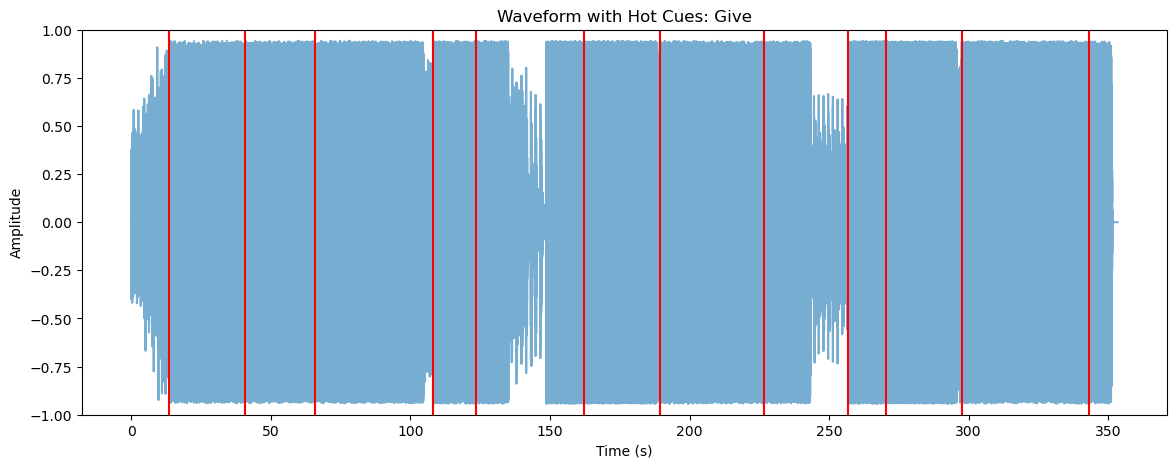

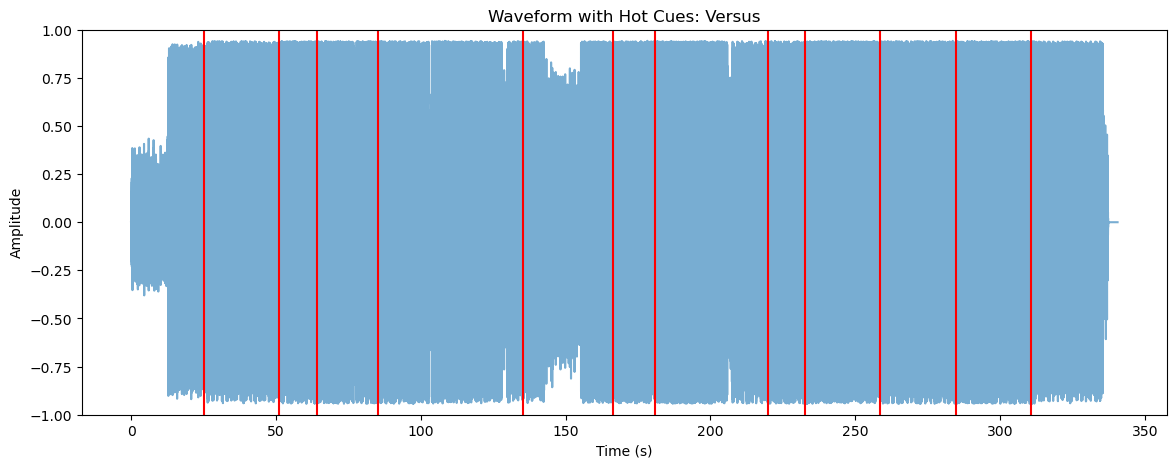

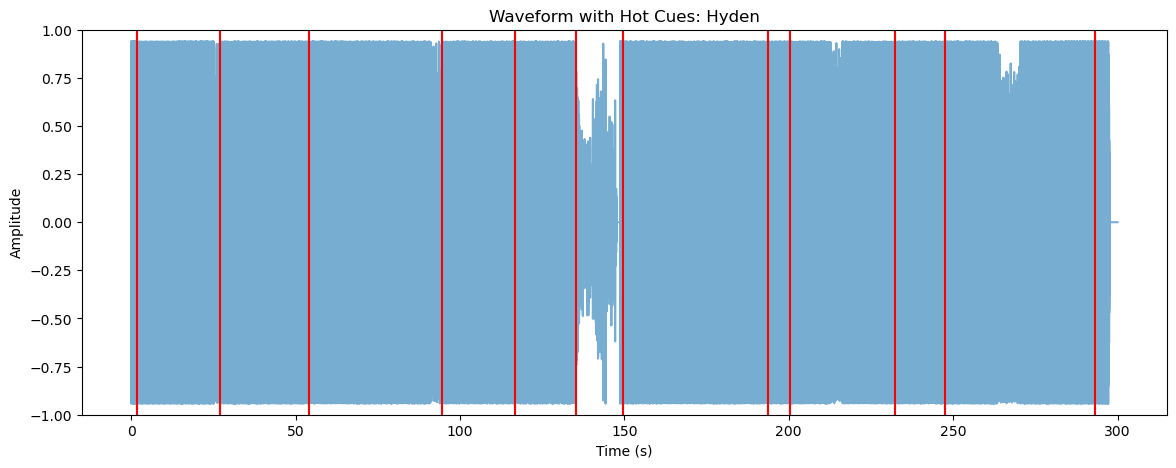

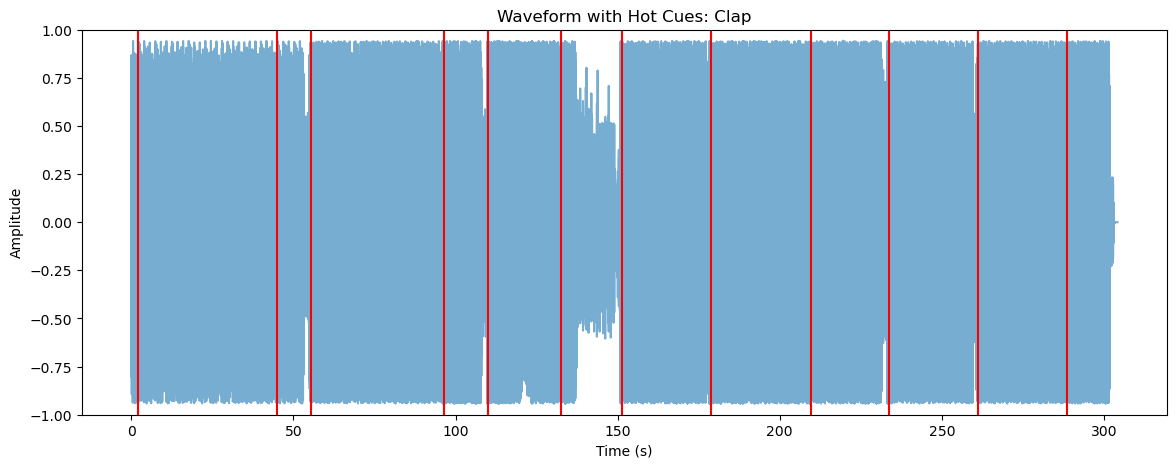

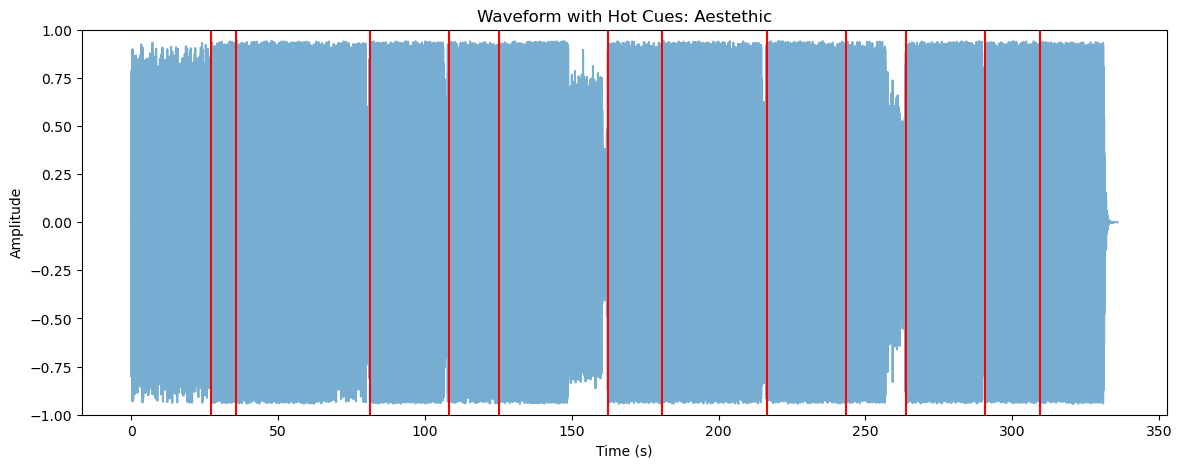

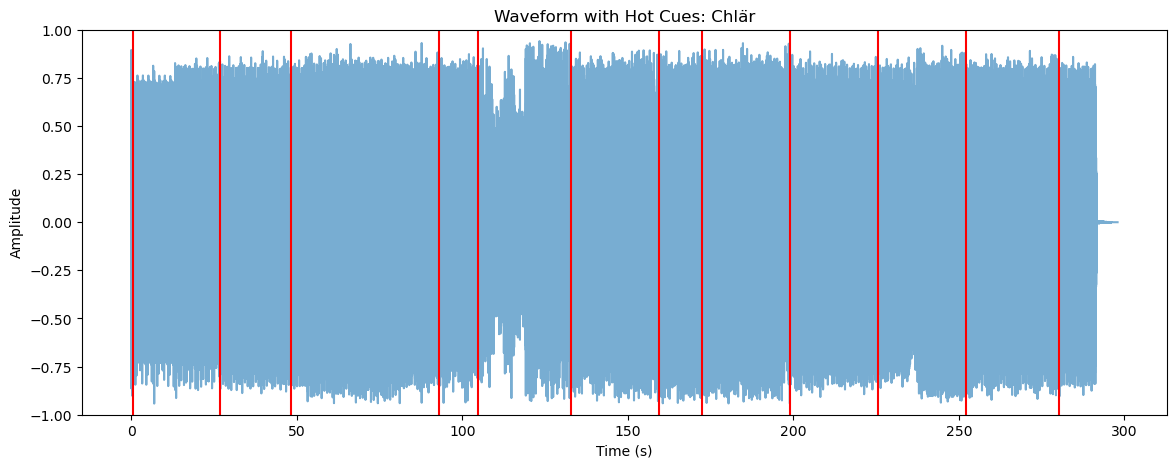

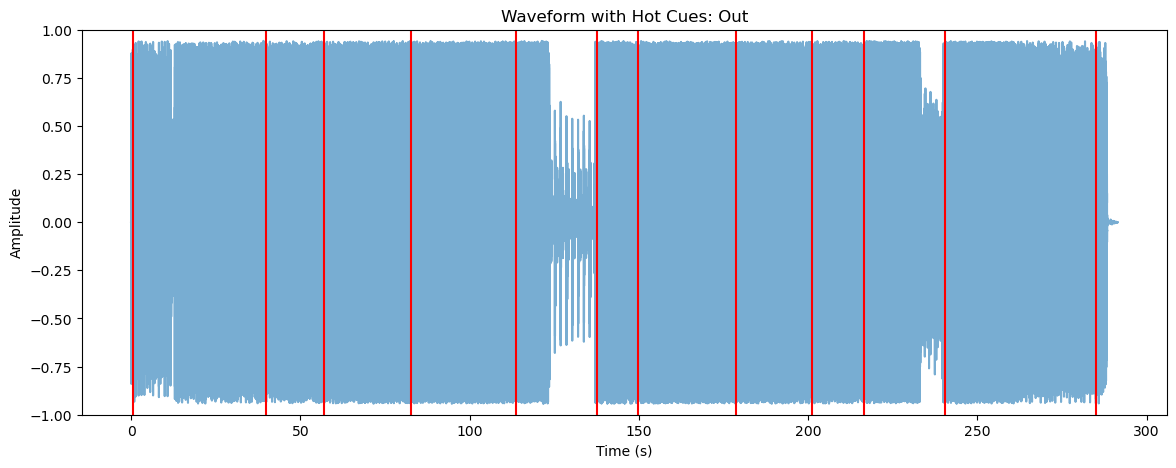

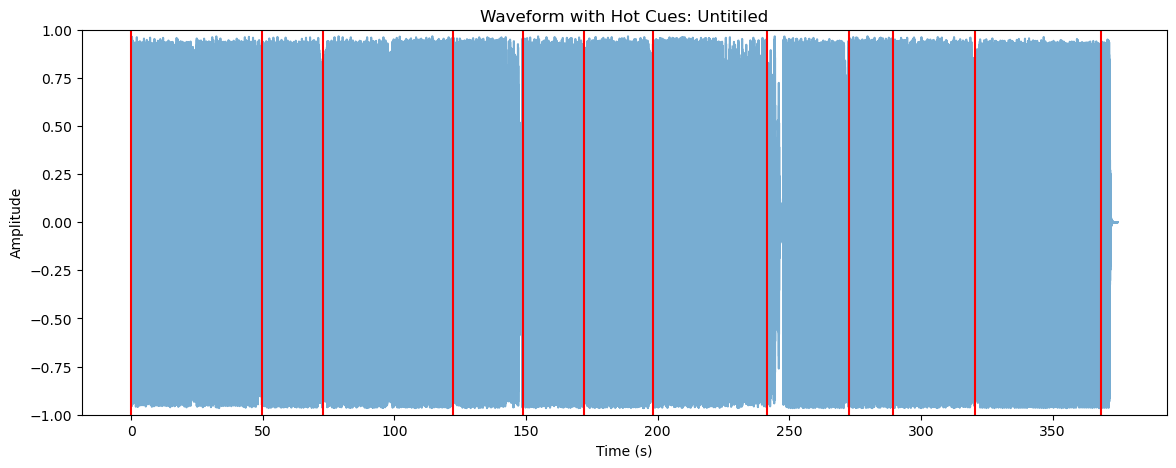

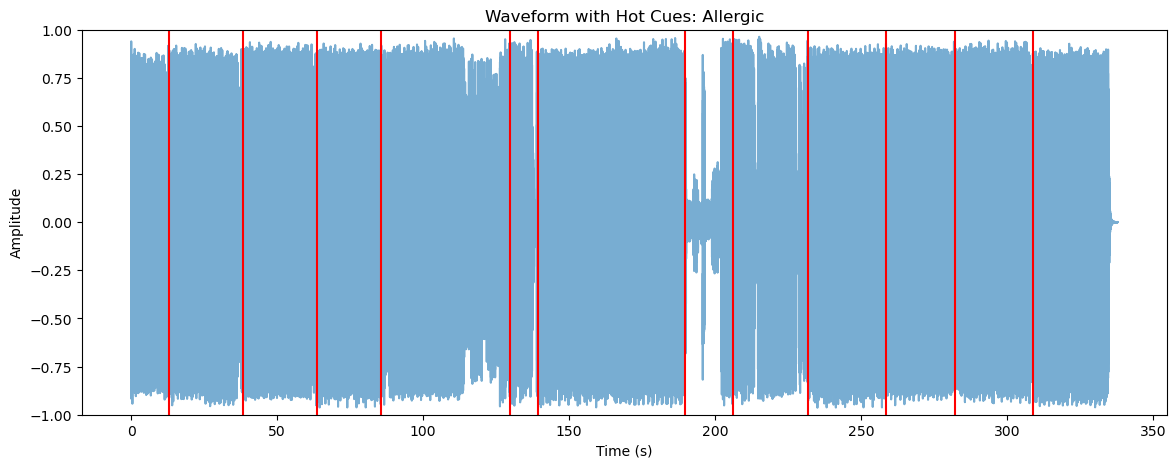

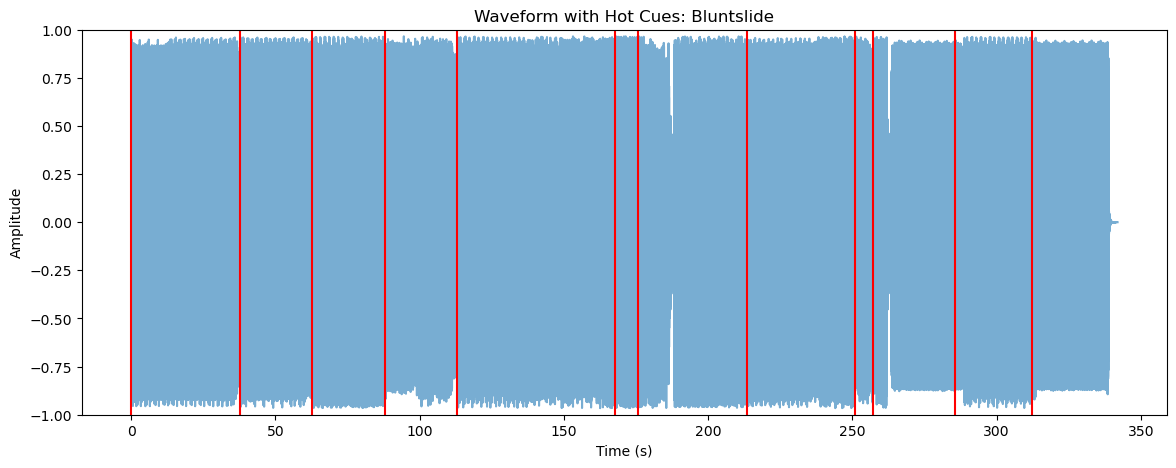

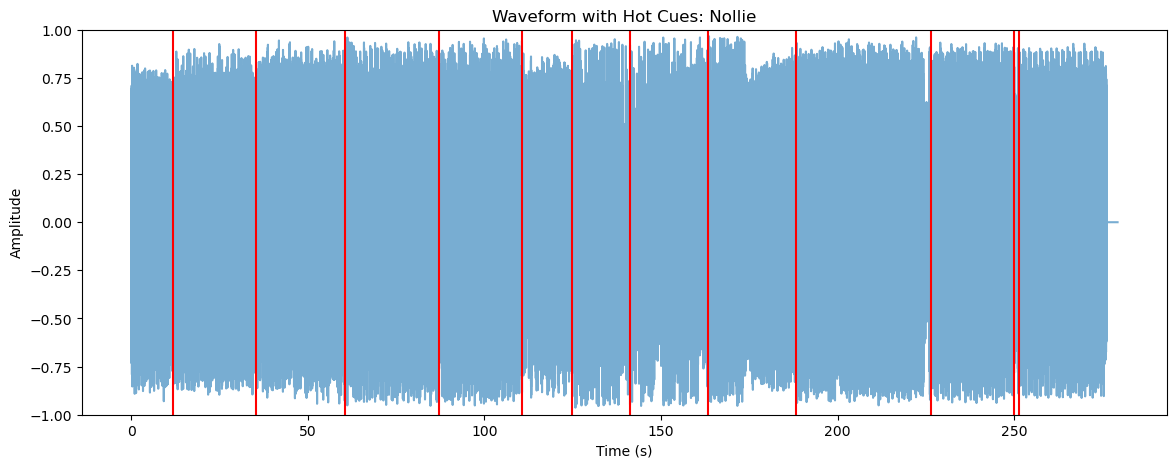

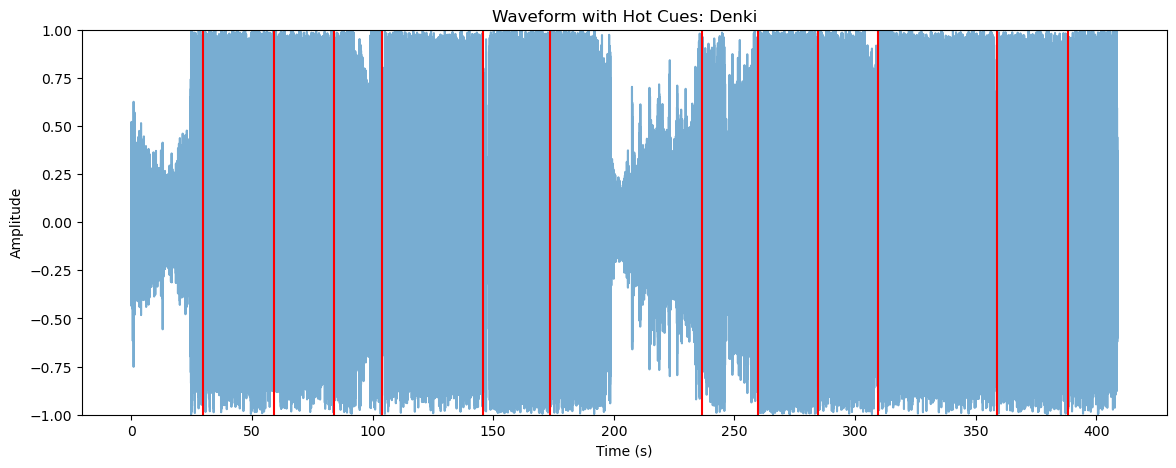

In [83]:
for track_name, track in new_data_dict.items():
    plot_waveform_with_hot_cues(track.audio, track.name, track.sr, track.cue_points)

In [53]:
# def get_cue_point_timestamps(track, cue_point_indices):
#     return [track.beats[i] for i in cue_point_indices]

In [54]:
# def generate_and_plot_cues_for_all_tracks(tracks_dict, cue_points_dict):
#     for track_name, track in tracks_dict.items():
#         cue_indices = cue_points_dict[track_name]
#         cue_timestamps = get_cue_point_timestamps(track, cue_indices)

#         print(f"Plotting for track: {track_name}")
#         plot_waveform_with_hot_cues(track.audio, track.sr, cue_timestamps)

# generate_and_plot_cues_for_all_tracks(new_data_dict, all_cue_points)

In [41]:
# # it was lstm model 1 but dont want to override it 

# torch.save(lstm_model.state_dict(), "lstm_model3.pth")

In [84]:
# # same here for the scaler 

# from joblib import dump

# dump(scaler, 'scaler3.joblib')